# Corporate Language as a Market Indicator: A Computational Study of Textual Data from S&P 500 Companies ​

## Data Import, Construction, and Cleaning

### Import the libraries 

In [1]:
# Importing necessary libraries for data manipulation, analysis, and visualization
import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, VBox, Button
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.patches as mpatches
from prophet import Prophet
from wordcloud import WordCloud
import ast
import textstat
from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import randint

### Loading the files and Function Definitions

In [2]:
# Path to the folder containing text files
folder_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/edgar_MgmtDisc'
#folder_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/prova'

# Path to the Loughran-McDonald Master Dictionary
lm_dictionary_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/Loughran-McDonald_MasterDictionary_1993-2023.csv'

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Function to clean text by removing non-alphabetic characters
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Function to load the Loughran-McDonald dictionary and extract positive and negative words
def load_lm_dictionary(dictionary_path):
    lm_dict = pd.read_csv(dictionary_path)
    positive_words = lm_dict[lm_dict['Positive'] != 0]['Word'].str.lower().tolist()
    negative_words = lm_dict[lm_dict['Negative'] != 0]['Word'].str.lower().tolist()
    return set(positive_words), set(negative_words)

# Function to perform sentiment analysis on text
def analyze_sentiment(text, positive_words, negative_words):
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(clean_text(text).lower()) if w not in stop_words]
    word_counts = Counter(words)
    total_words = len(words)
    
    positive_score = sum(word_counts[word] for word in positive_words if word in word_counts)
    negative_score = sum(word_counts[word] for word in negative_words if word in word_counts)
    
    sentiment_expressive_count = positive_score + negative_score
    
    if total_words > 0:
        balance = (positive_score - negative_score) / sentiment_expressive_count if sentiment_expressive_count > 0 else 0
        density = sentiment_expressive_count / total_words
        amplification_factor = 10  # we are using this 'amplification factor' to increase the values
        sentiment_score = balance * density * amplification_factor
    else:
        sentiment_score = 0  

    return sentiment_score, word_counts, {word: word_counts[word] for word in positive_words if word in word_counts}, \
           {word: word_counts[word] for word in negative_words if word in word_counts}

# Function to get top n sentiment words
def top_n_sentiment_words(word_counts, positive_word_freq, negative_word_freq, n=20):
    top_words = Counter({word: word_counts[word] for word in positive_word_freq.keys() | negative_word_freq.keys()})
    filtered_words = {word: count for word, count in top_words.items() if word.isalpha()}
    return [(word, count) for word, count in Counter(filtered_words).most_common(n)]

# Function to categorize sentiment score
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score > 0.05:
        return 'Slightly Positive'
    elif score > -0.05:
        return 'Neutral'
    elif score > -0.1:
        return 'Slightly Negative'
    else:
        return 'Negative'

# Function to count words in text
def count_words(text):
    cleaned_text = clean_text(text)
    words = word_tokenize(cleaned_text)
    return len(words)

# Function to find repeated phrases in text
def find_repeated_phrases(text, n=4):
    cleaned_text = clean_text(text).lower()
    words = word_tokenize(cleaned_text)
    phrases = ngrams(words, n)
    phrase_counts = Counter(phrases)
    return {phrase: count for phrase, count in phrase_counts.items() if count > 1}

# Function to calculate boilerplate percentage
def calculate_boilerplate_percentage(text, repeated_phrases, n=4, relative_threshold=0.01):
    total_words = len(word_tokenize(text))
    total_repeated_words = 0

    for phrase, count in repeated_phrases.items():
        if (count * n) / total_words >= relative_threshold:
            total_repeated_words += count * n

    unique_repeated_words = total_repeated_words / n  
    return (unique_repeated_words / total_words) * 100

# Define function to count sentences
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Function to calculate the maximum sentence length
def max_sentence_length(text):
    sentences = re.split(r'\.\s+', text)  # This is the splitting of the text into sentences using .(periods) followed by a ' '(space)
    max_length = max(len(sentence.split()) for sentence in sentences)
    return max_length

# Function to calculate readability indices
def readability_indices(text):
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    gunning_fog = textstat.gunning_fog(text)
    return flesch_reading_ease, flesch_kincaid_grade, gunning_fog

# Finally load the Loughran and McDonald dictionary
positive_words, negative_words = load_lm_dictionary(lm_dictionary_path)

data = []

### Create DataFrame

##### ! skip the execution of the following 2 cells and load the csv at the beginning of the EDA phase !

In [ ]:
# Loop through each file in our folder, extract relevant data and perform analysis
for filename in os.listdir(folder_path):
    with open(os.path.join(folder_path, filename), 'r') as file:
        text = file.read()

        # Extracting cik, company and date
        cik = text.split('CIK:')[1].split('\n')[0].strip()
        company_name = text.split('Company Name:')[1].split('\n')[0].strip()
        filing_date = text.split('Filing Date:')[1].split('\n')[0].strip()

        # Perform sentiment analysis
        sentiment_score, word_counts, sorted_positive_word_freq, sorted_negative_word_freq = analyze_sentiment(text, positive_words, negative_words)
        sentiment_category = categorize_sentiment(sentiment_score)

        # Identify key sentiment words and word count
        key_sentiment_words = top_n_sentiment_words(word_counts, sorted_positive_word_freq, sorted_negative_word_freq)
        word_count = count_words(text)

        # Boilerplate analysis
        repeated_phrases = find_repeated_phrases(text)
        boilerplate_percentage = calculate_boilerplate_percentage(text, repeated_phrases)

        # Count sentences
        sentence_count = count_sentences(text)
        
        # Calculate maximum sentence length and readability indices
        max_sentence_len = max_sentence_length(text)
        flesch_reading_ease, flesch_kincaid_grade, gunning_fog = readability_indices(text)

        # Append all data to the DataFrame list
        data.append([company_name, cik, filing_date, word_count, sentiment_score, sentiment_category, sorted_positive_word_freq, sorted_negative_word_freq, key_sentiment_words, boilerplate_percentage, sentence_count, max_sentence_len, flesch_reading_ease, flesch_kincaid_grade, gunning_fog])

# Create the DataFrame
df = pd.DataFrame(data, columns=['Company', 'CIK', 'Date', 'Word Count', 'Sentiment Score', 'Sentiment Category', 'Positive Words', 'Negative Words', 'Key Sentiment Words', 'Boilerplate Percentage', 'Sentence Count', 'Max Sentence Length', 'Flesch Reading Ease', 'Flesch-Kincaid Grade Level', 'Gunning-Fog Index'])


### Data Cleaning and Manipulation

In [ ]:
# ----- Data Manipulation -----

### Preprocessing Steps

# Data manipulation and cleaning steps

df['CIK'] = df['CIK'].astype(str)

# Dropping documents with few words, not useful for our purposes
df = df[~((df['CIK'] == '80424') & (df['Word Count'] < 1000))]

# Check if companies changed their name during the years: CIK, count of unique company names, and the company names themselves
cik_info = df.groupby('CIK')['Company'].agg(['nunique', lambda x: ', '.join(x.unique())])
cik_info.columns = ['Number of Unique Company Names', 'Associated Company Names']

# Filtering to include only those CIKs with more than one unique company name
cik_info = cik_info[cik_info['Number of Unique Company Names'] > 1]
print("CIKs with Multiple Associated Company Names:")
print(cik_info)

# Some companies modified their company name three times during the last 20 years, thus we will use just one
df.loc[df['CIK'] == '320193', 'Company'] = 'APPLE INC'
df.loc[df['CIK'] == '1326801', 'Company'] = 'META PLATFORMS INC'
df.loc[df['CIK'] == '796343', 'Company'] = 'ADOBE INC'
df.loc[df['CIK'] == '356028', 'Company'] = 'CA INC'
df.loc[df['CIK'] == '51143', 'Company'] = 'IBM INC'
df.loc[df['CIK'] == '1002047', 'Company'] = 'NETAPP INC'
df.loc[df['CIK'] == '1018963', 'Company'] = 'ATI INC'
df.loc[df['CIK'] == '1120193', 'Company'] = 'NASDAQ INC'
df.loc[df['CIK'] == '1138118', 'Company'] = 'CBRE GROUP INC'
df.loc[df['CIK'] == '1282266', 'Company'] = 'WINDSTREAM HOLDINGS INC'
df.loc[df['CIK'] == '1521332', 'Company'] = 'APTIV PLC'
df.loc[df['CIK'] == '18926', 'Company'] = 'LUMEN TECHNOLOGIES INC'
df.loc[df['CIK'] == '47111', 'Company'] = 'HERSHEY CO'
df.loc[df['CIK'] == '64803', 'Company'] = 'CVS HEALTH CORP'
df.loc[df['CIK'] == '69499', 'Company'] = 'MYLAN INC'
df.loc[df['CIK'] == '813828', 'Company'] = 'PARAMOUNT GLOBAL'
df.loc[df['CIK'] == '814453', 'Company'] = 'NEWELL BRANDS INC'
df.loc[df['CIK'] == '822416', 'Company'] = 'PULTEGROUP INC MI'
df.loc[df['CIK'] == '87347', 'Company'] = 'SCHLUMBERGER LIMITED NV'
df.loc[df['CIK'] == '883569', 'Company'] = 'FOSSIL GROUP INC'
df.loc[df['CIK'] == '927066', 'Company'] = 'DAVITA INC'
df.loc[df['CIK'] == '935703', 'Company'] = 'DOLLAR TREE INC'
df.loc[df['CIK'] == '945764', 'Company'] = 'DENBURY INC'

# Check if companies changed their name during the years: CIK, count of unique company names, and the company names themselves
cik_info = df.groupby('CIK')['Company'].agg(['nunique', lambda x: ', '.join(x.unique())])
cik_info.columns = ['Number of Unique Company Names', 'Associated Company Names']

# Filtering to include only those CIKs with more than one unique company name
cik_info = cik_info[cik_info['Number of Unique Company Names'] > 1]
print("CIKs with Multiple Associated Company Names:")
print(cik_info)

# Convert the 'Date' column to datetime for easier manipulation
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the date for annual trend analysis
df['Year'] = df['Date'].dt.year

# Calculate the total number of unique companies
total_companies = df['Company'].nunique()

# Count the number of companies per year
companies_per_year = df.groupby('Year')['Company'].nunique()

# Create a new column for the ratio
df['Company Presence by Year'] = df['Year'].apply(lambda x: f"{companies_per_year[x]}/{total_companies}")

# Calculate the total number of reports by company over the last 20 years (2004 to 2023)
# Count the occurrences of each CIK and Company combination in the dataframe
report_counts = df.groupby(['CIK', 'Company']).size()

# Create a new column 'Total Reports by Company' which will hold the ratio of actual reports to the possible 20 (years 2004 to 2023)
df['Total Reports by Company'] = df.apply(lambda row: f"{report_counts[(row['CIK'], row['Company'])]}/20" if (row['CIK'], row['Company']) in report_counts.index else '0/20', axis=1)

#df.to_csv('output100sent.csv', index=False)


## Explanatory Data Analysis (EDA)

### Correlation between Word Count and Sentiment Score

In [3]:
## Exporting to a CSV file
#df.to_csv('output100sent.csv', index=False)

## Importing the dataset to save time by skipping the execution of the third cell
df=pd.read_csv('output100sent.csv')



In [4]:
################################################## EDA ################################################

# ------- Calculating the correlation between 'Word Count' and 'Sentiment Score'

# Calculate the correlations
correlation = df[['Word Count', 'Sentiment Score']].corr()

# Print the correlations
print("Correlation between Word Count and Sentiment Score:", correlation.at['Word Count', 'Sentiment Score'])

# Calculate correlation by year
yearly_correlation = df.groupby('Year').apply(lambda x: x[['Word Count', 'Sentiment Score']].corr().iloc[0, 1])

# Reset index to turn the Series into a DataFrame for plotting
yearly_correlation_df = yearly_correlation.reset_index()
yearly_correlation_df.columns = ['Year', 'Correlation']

# Creating an interactive line plot using Plotly
fig = px.line(yearly_correlation_df, x='Year', y='Correlation', 
              title='Yearly Correlation Between Word Count and Sentiment Score',
              markers=True,  
              labels={'Correlation': 'Correlation Coefficient'})

# Add a horizontal line for the average correlation and update layout
average_correlation = -0.31
fig.add_hline(y=average_correlation, line_dash="dot",
              annotation_text=f"Average Correlation: {average_correlation:.2f}", 
              annotation_position="bottom right")
fig.update_traces(text='Correlation', hoverinfo='x+y', name='Yearly Correlation')  

# Adding details to the plot
fig.update_layout(
    plot_bgcolor='white',  
    hovermode='x unified',  
    xaxis_title='Year',
    yaxis_title='Correlation Coefficient',
    xaxis=dict(
        showline=True, 
        showgrid=True,  
        tickmode='linear',
        tick0=df['Year'].min(),
        dtick=1,  
        linecolor='gray', 
        gridcolor='lightgray'  
    ),
    yaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='gray',
        gridcolor='lightgray'
    ),
    legend_title='Legend',
    legend=dict(y=1, x=1, xanchor='right', yanchor='top'),  
    font=dict(  
        family="Arial, sans-serif",
        size=12,
        color="black"
    )
)

fig.write_html('yearly_correlation_plot.html')
fig.show()

Correlation between Word Count and Sentiment Score: -0.31362887563029346


### Word Count analysis

#### Word Count Distribution and Trend Over Time

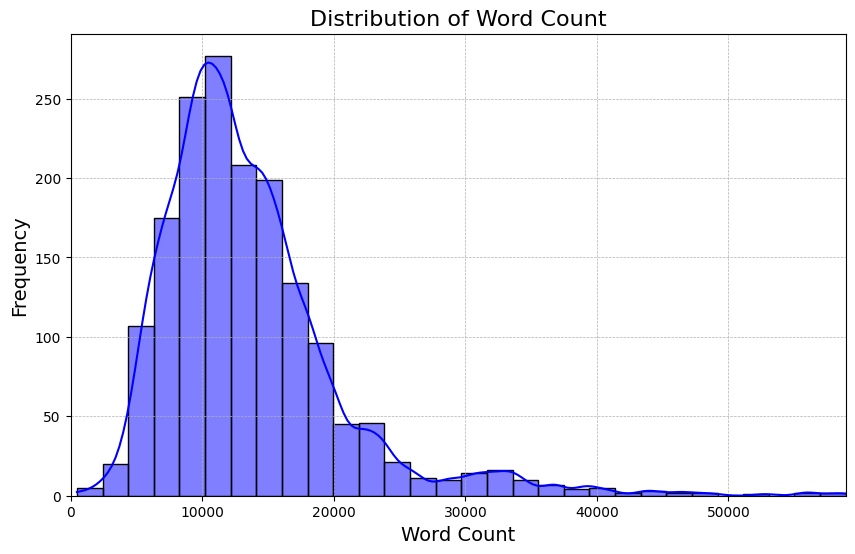

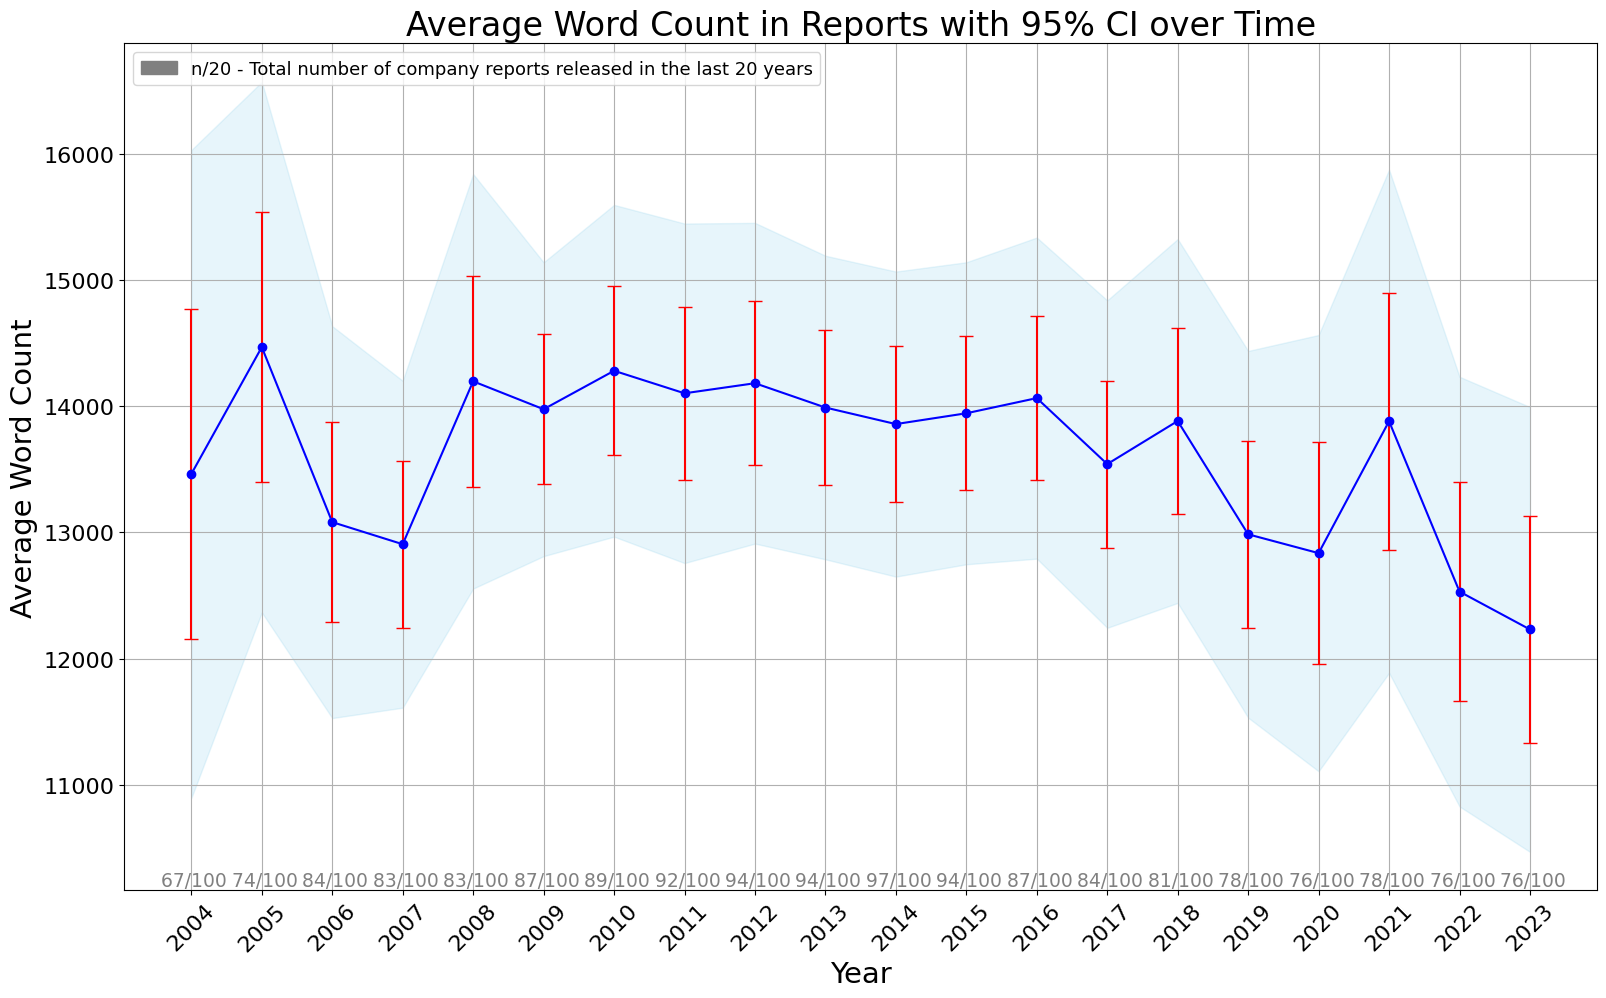

In [5]:
# Creating word count distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Word Count'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, df['Word Count'].max())
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Calculate mean and SEM per year
average_word_count_by_year = df.groupby('Year')['Word Count'].mean().reset_index()
average_word_count_by_year['SEM'] = df.groupby('Year')['Word Count'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05  # Significance level for 95% CI
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))  # Critical z-value for 95% CI
ci_half_width = z_score * average_word_count_by_year['SEM']  

# Merge 'Company Presence' data in order to add information on the plots
average_word_count_by_year = average_word_count_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Creating the graph 'Average Word Count in Reports with 95% CI over Time'
plt.figure(figsize=(19, 11))

# Mean and confidence interval
sns.lineplot(
    data=average_word_count_by_year,
    x='Year',
    y='Word Count',
    marker='o',
    color='blue',
    label='Average Word Count'
)
plt.fill_between(
    average_word_count_by_year['Year'],
    (average_word_count_by_year['Word Count'] - ci_half_width),
    (average_word_count_by_year['Word Count'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_word_count_by_year['Year'],
    average_word_count_by_year['Word Count'],
    yerr=average_word_count_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations below the x-axis
for i, row in average_word_count_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper left', fontsize=13)

# Labels and title
plt.title('Average Word Count in Reports with 95% CI over Time', fontsize=24)
plt.xlabel('Year', fontsize=21)
plt.ylabel('Average Word Count', fontsize=21)
plt.xticks(average_word_count_by_year['Year'], rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()


#### Top Companies by Avg. Word Count

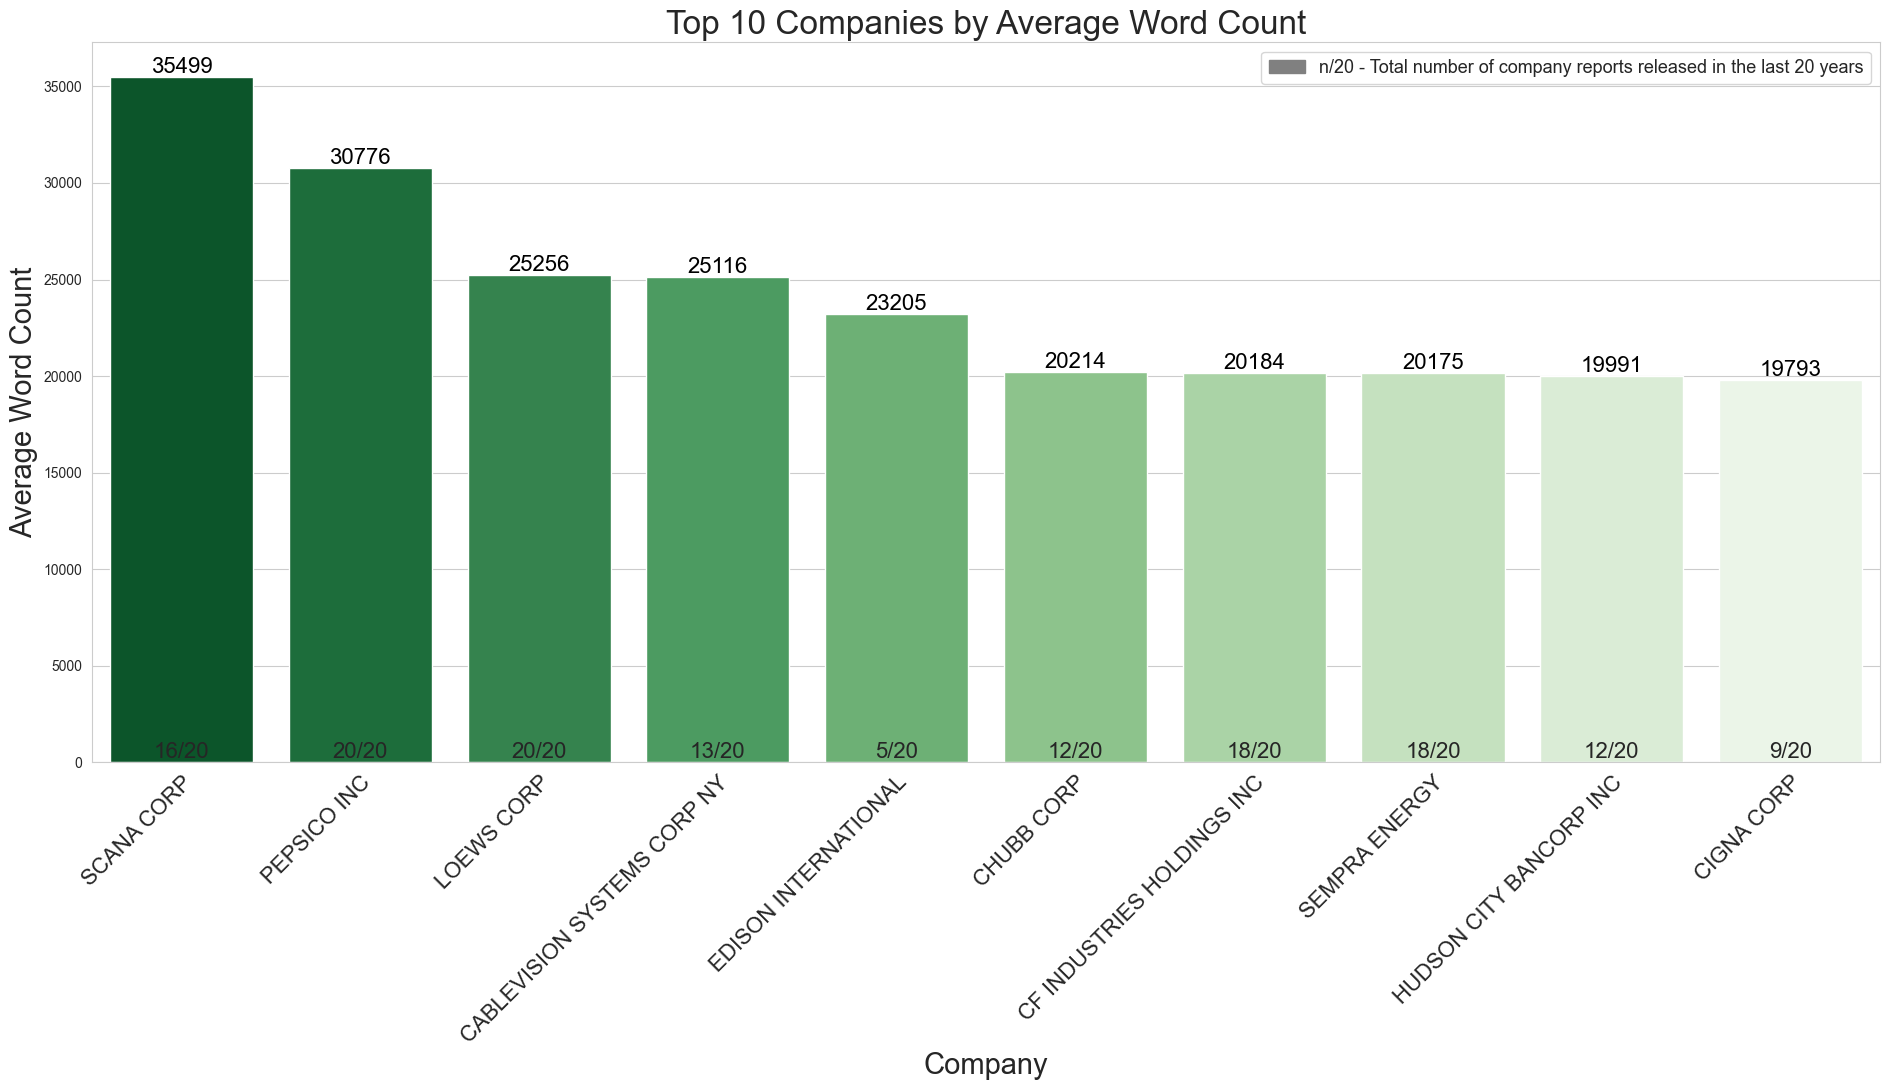

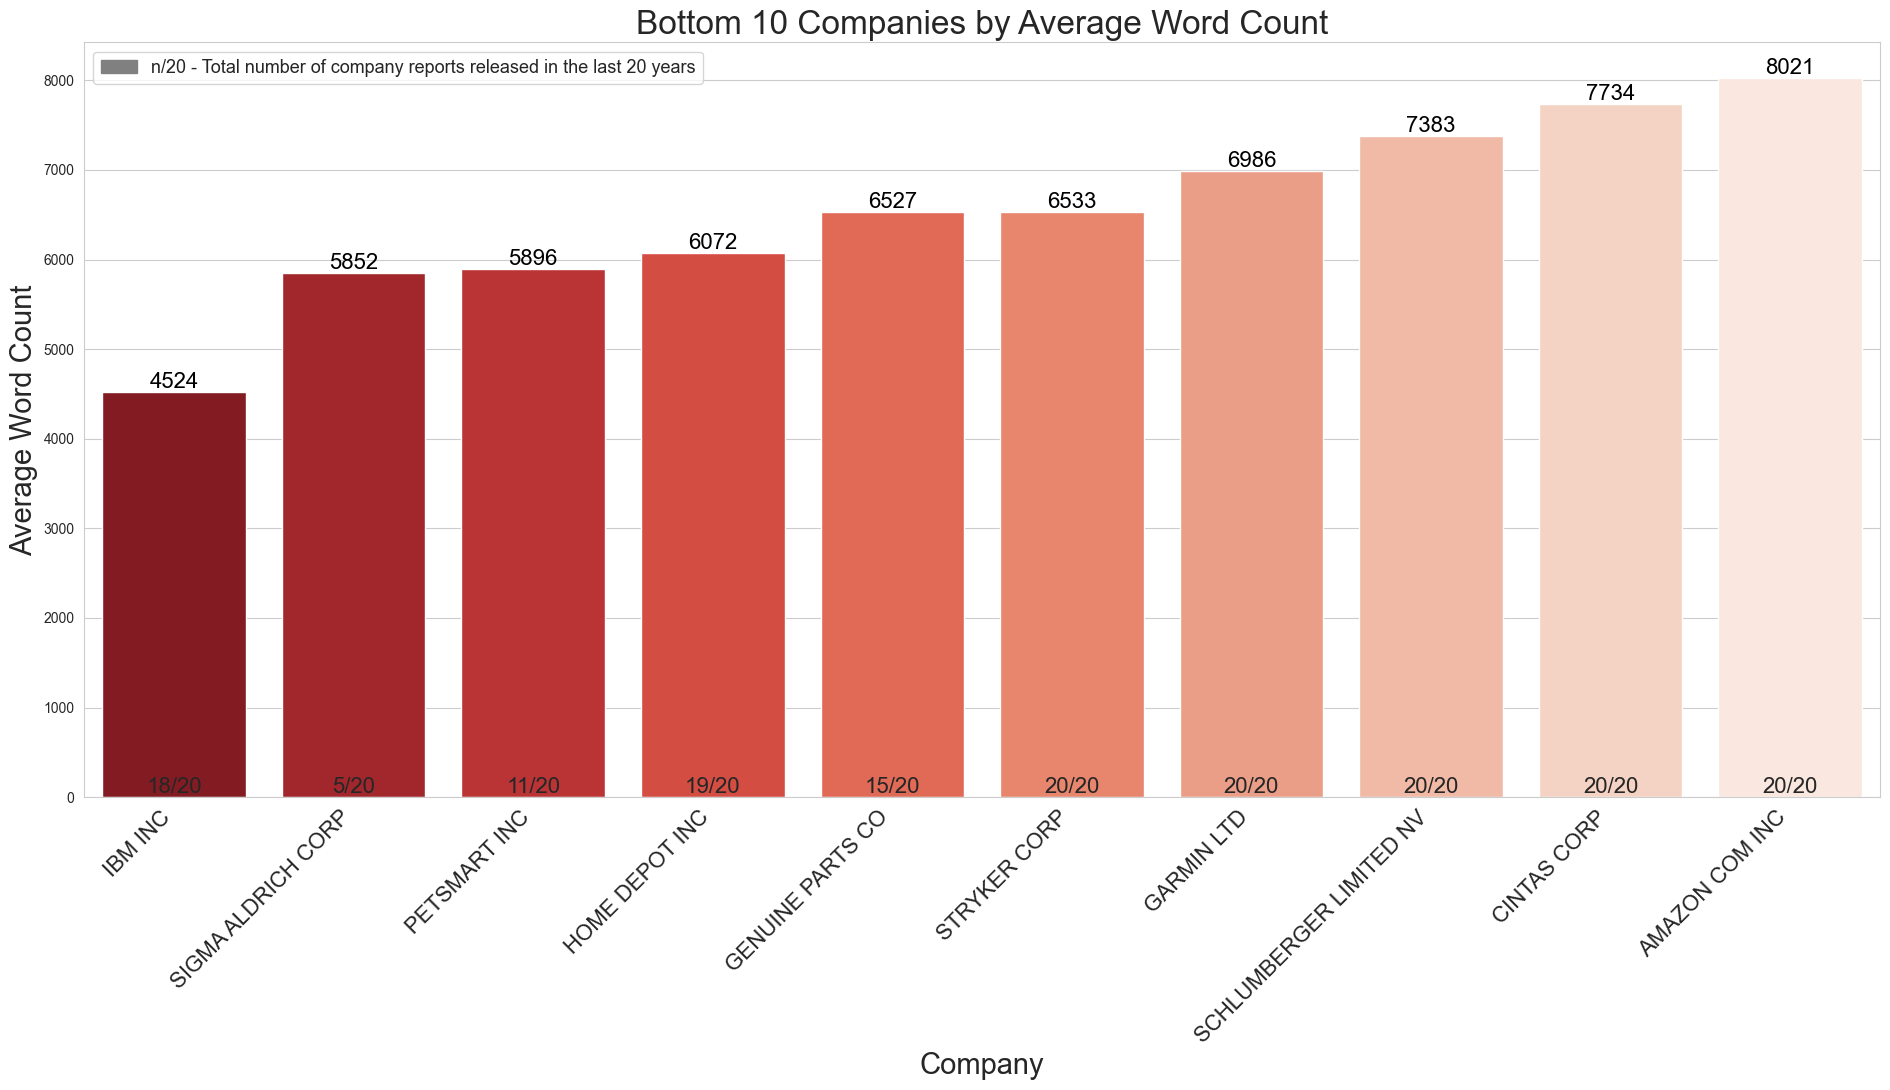

In [6]:
# Plot - Top 10 companies by average word count
top_companies_by_word_count = df.groupby('Company')['Word Count'].mean().nlargest(10).index
top_companies_df = df[df['Company'].isin(top_companies_by_word_count)]

plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
top_bar = sns.barplot(
    data=top_companies_df,
    x='Company', 
    y='Word Count',
    estimator=np.mean,
    errorbar=None,
    palette='Greens_r',
    order=top_companies_by_word_count
)

# Adjust the position of the company names on the x-axis
top_bar.set_xticklabels(top_bar.get_xticklabels(), rotation=45, horizontalalignment='right', verticalalignment='top', fontsize=16, rotation_mode="anchor")

# Annotating each bar with its value and 'Total Reports by Company'
for index, p in enumerate(top_bar.patches):
    height = p.get_height()
    company_presence = top_companies_df.loc[top_companies_df['Company'] == top_bar.get_xticklabels()[index].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., height , f'{int(height)}', ha="center", va='bottom', fontsize=16, color='black')
    plt.text(p.get_x() + p.get_width() / 2., -5, f'{company_presence}', ha="center", va='bottom', fontsize=16)

# Legend and title
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)
top_bar.set_title('Top 10 Companies by Average Word Count', fontsize=24)
top_bar.set_xlabel('Company', fontsize=21)
top_bar.set_ylabel('Average Word Count', fontsize=21)
plt.tight_layout()
plt.show()

# Repeat for the bottom 10 companies
bottom_companies_by_word_count = df.groupby('Company')['Word Count'].mean().nsmallest(10).index
bottom_companies_df = df[df['Company'].isin(bottom_companies_by_word_count)]

plt.figure(figsize=(19, 11))
bottom_bar = sns.barplot(
    data=bottom_companies_df,
    x='Company', 
    y='Word Count',
    estimator=np.mean,
    errorbar=None,
    palette='Reds_r',
    order=bottom_companies_by_word_count
)

bottom_bar.set_xticklabels(bottom_bar.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16, verticalalignment='top')

# Annotate each bar with its value and 'Total Reports by Company'
for index, p in enumerate(bottom_bar.patches):
    height = p.get_height()
    company_presence = bottom_companies_df.loc[bottom_companies_df['Company'] == bottom_bar.get_xticklabels()[index].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., height , f'{int(height)}', ha="center", va='bottom', fontsize=16, color='black')
    plt.text(p.get_x() + p.get_width() / 2., 0, f'{company_presence}', ha="center", va='bottom', fontsize=16)

# Legend and title settings
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper left', fontsize=13)
bottom_bar.set_title('Bottom 10 Companies by Average Word Count', fontsize=24)
bottom_bar.set_xlabel('Company', fontsize=21)
bottom_bar.set_ylabel('Average Word Count', fontsize=21)
plt.tight_layout()
plt.show()

#### Top Companies by Average Word Count by Year

In [7]:
# Function to plot data for the selected year
def plot_data(year):
    global fig, ax  
    # Filter data for the selected year
    filtered_df = df[df['Year'] == int(year)]
    
    # Top 5 and bottom 5 companies by Word Count
    top_companies = filtered_df.nlargest(5, 'Word Count').sort_values('Word Count', ascending=False)
    bottom_companies = filtered_df.nsmallest(5, 'Word Count').sort_values('Word Count', ascending=False)
    
    # Concatenating top and bottom companies
    combined_df = pd.concat([top_companies, bottom_companies])
    
    # Calculate percentage change from the previous year
    previous_year_df = df[df['Year'] == int(year) - 1]
    combined_df = combined_df.merge(previous_year_df[['Company', 'Word Count']], on='Company', how='left', suffixes=('', '_prev'))
    combined_df['Percentage Change'] = ((combined_df['Word Count'] - combined_df['Word Count_prev']) / combined_df['Word Count_prev'] * 100).fillna(0)
    colors = ['green' if x in top_companies['Word Count'].values else 'red' for x in combined_df['Word Count']]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.barh(combined_df['Company'], combined_df['Word Count'], color=colors)
    ax.set_xlabel('Word Count')
    ax.set_title(f'Top and Bottom 5 Companies by Word Count in {year}')
    
    # Annotate each bar with its value
    for bar, change in zip(bars, combined_df['Percentage Change']):
        width = bar.get_width()
        label_x_pos = width + 5
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width} ({change:+.2f}%)', va='center')

    max_word_count = combined_df['Word Count'].max()
    ax.set_xlim(0, max_word_count * 1.18)

    # Add a legend (to differentiate between Top and Bottom companies)
    top_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor = 'none')
    bottom_bar = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
    ax.legend([top_bar, bottom_bar], ['Top 5 Companies', 'Bottom 5 Companies'], loc='upper right')
    plt.show()

# Function to save the plot as PNG
def save_plot(_):
    filename = f'top_bottom_companies_word_count_{year_dropdown.value}.png'
    fig.savefig(filename, format='png')
    print(f'Plot saved as {filename}')

# Dropdown for selecting the year
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in sorted(df['Year'].unique())],
    value=str(sorted(df['Year'].unique())[0]),
    description='Year:',
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)
ui = VBox([year_dropdown, save_button])

# Linking the dropdown widget
interact(plot_data, year=year_dropdown)
display(ui)



interactive(children=(Dropdown(description='Year:', options=('2004', '2005', '2006', '2007', '2008', '2009', '…

#### Word Count Over Time by Company

In [8]:
# Plot - Word Count over time by Company
def plot_data(selected_companies):
    global fig  
    fig = go.Figure()

    if not selected_companies:
        avg_data = df.groupby('Year')['Word Count'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=avg_data['Year'],
            y=avg_data['Word Count'],
            mode='lines+markers',
            name='Average Word Count',
            hoverinfo='all'
        ))
        title_text = "Average Word Count Across All Companies"
    else:
        max_word_count = 0
        company_names = []

        for company in selected_companies:
            company_data = df[df['Company'] == company].sort_values('Year')
            current_max = company_data['Word Count'].max()
            if current_max > max_word_count:
                max_word_count = current_max

            fig.add_trace(go.Scatter(
                x=company_data['Year'],
                y=company_data['Word Count'],
                mode='lines+markers',
                name=company,
                hoverinfo='all'
            ))

            company_names.append(company)

        title_text = f"Word Count Time Series for {' & '.join(company_names)}"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Word Count',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

# Function to save the plot
def save_plot(_):
    if not company_dropdown.value:
        filename = 'average_word_count_across_all_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'word_count_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown for selecting the company with multiple-selections
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    description='Company:',
    disabled=False
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)

# Displaying the plot
ui = VBox([company_dropdown, save_button])
interact(plot_data, selected_companies=company_dropdown)
display(ui)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######


interactive(children=(SelectMultiple(description='Company:', options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE IN…

### Sentiment Score Analysis

#### Sentiment Score Distribution and Trend Over Time


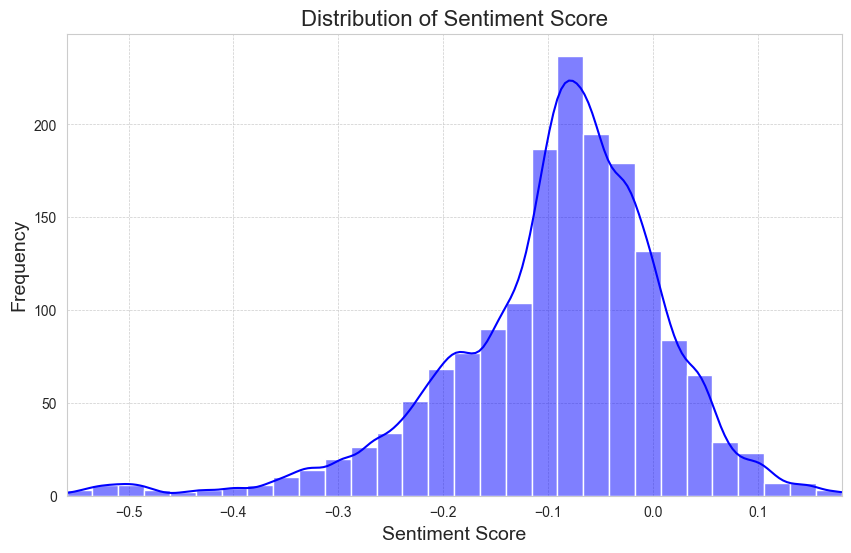

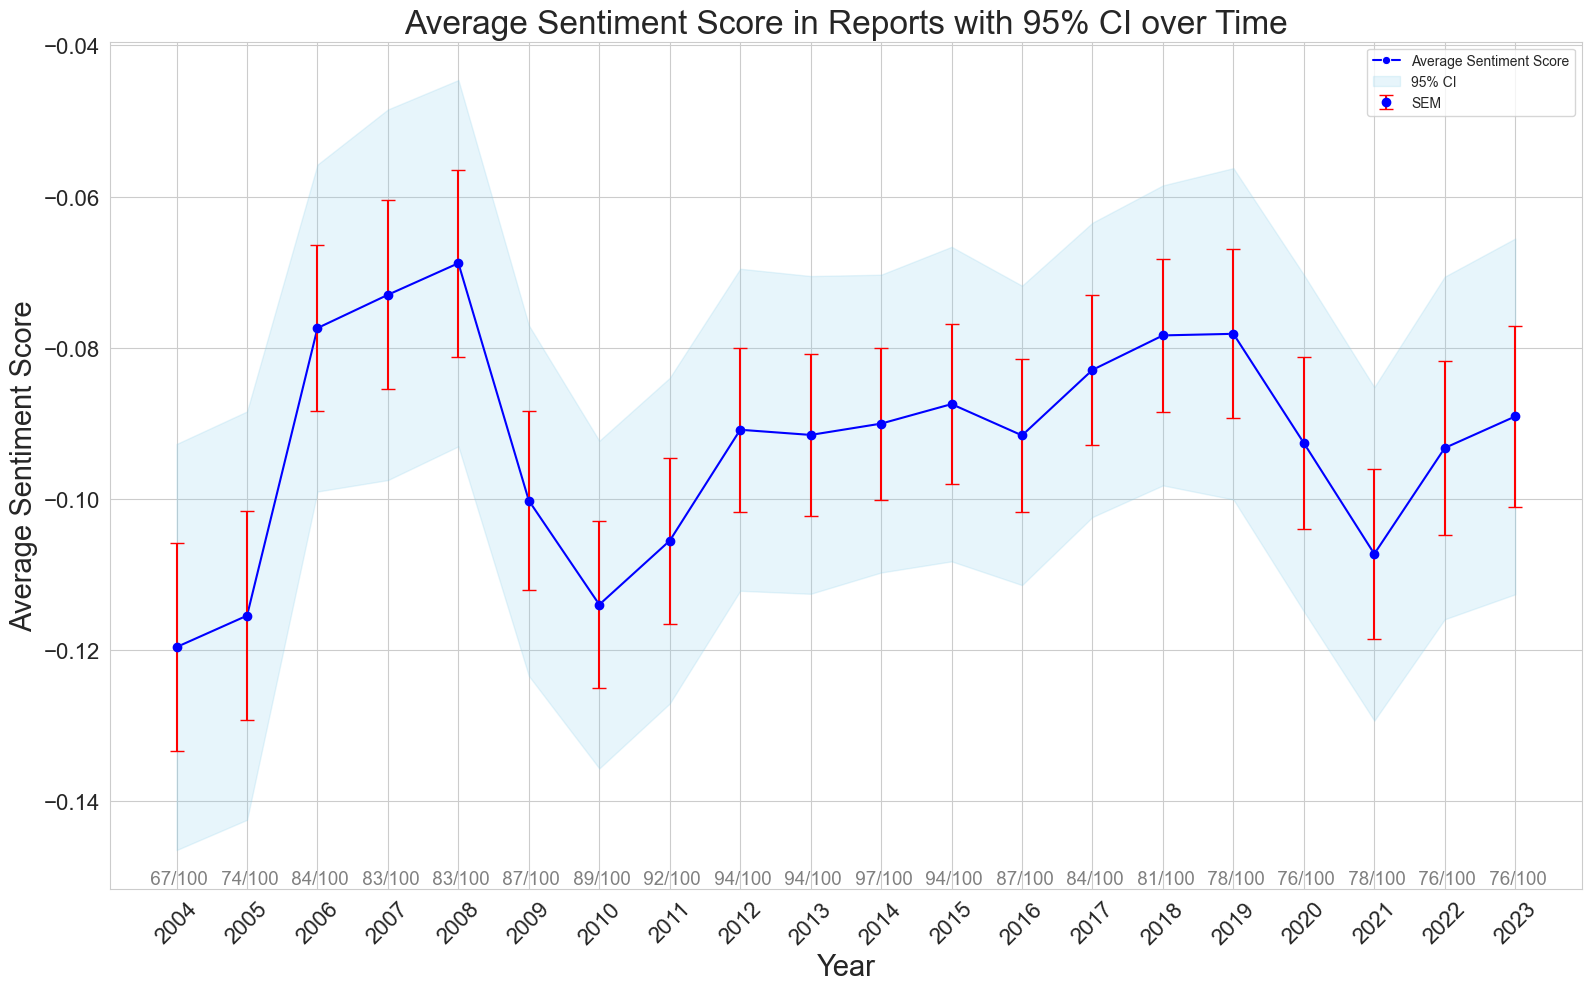

In [9]:
# Plot - Sentiment score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment Score'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Sentiment Score', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(df['Sentiment Score'].min(), df['Sentiment Score'].max())
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Calculate mean and SEM per year for Sentiment Score
average_sentiment_by_year = df.groupby('Year')['Sentiment Score'].mean().reset_index()
average_sentiment_by_year['SEM'] = df.groupby('Year')['Sentiment Score'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))
ci_half_width = z_score * average_sentiment_by_year['SEM']

# Merge 'Company Presence' data 
average_sentiment_by_year = average_sentiment_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot - Ssentimetn Score over time
plt.figure(figsize=(19, 11))

# Mean and confidence interval
sns.lineplot(
    data=average_sentiment_by_year,
    x='Year',
    y='Sentiment Score',
    marker='o',
    color='blue',
    label='Average Sentiment Score'
)
plt.fill_between(
    average_sentiment_by_year['Year'],
    (average_sentiment_by_year['Sentiment Score'] - ci_half_width),
    (average_sentiment_by_year['Sentiment Score'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_sentiment_by_year['Year'],
    average_sentiment_by_year['Sentiment Score'],
    yerr=average_sentiment_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations below the x-axis
for i, row in average_sentiment_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

# Labels and title
plt.title('Average Sentiment Score in Reports with 95% CI over Time', fontsize=24)
plt.xlabel('Year', fontsize=21)
plt.ylabel('Average Sentiment Score', fontsize=21)
plt.xticks(average_sentiment_by_year['Year'], rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.show()



#### Top companies by Avg. Sentiment Score

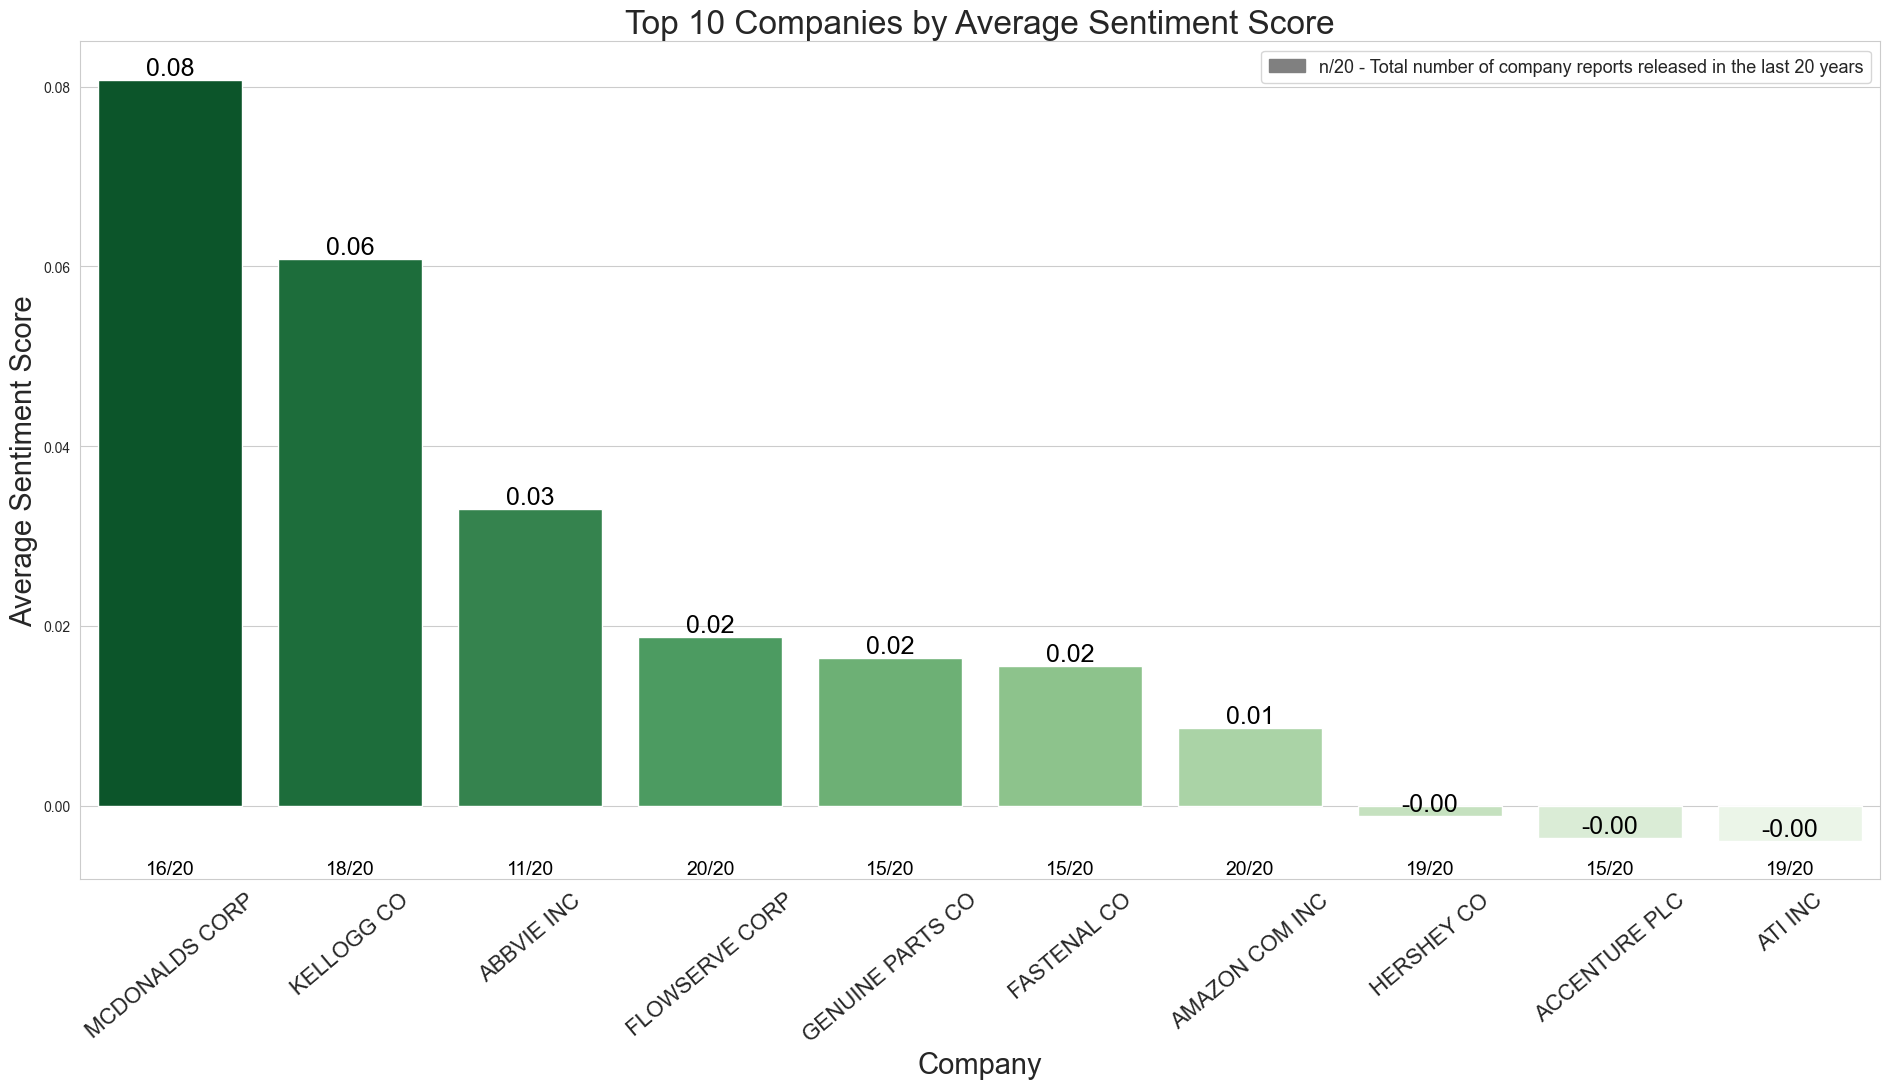

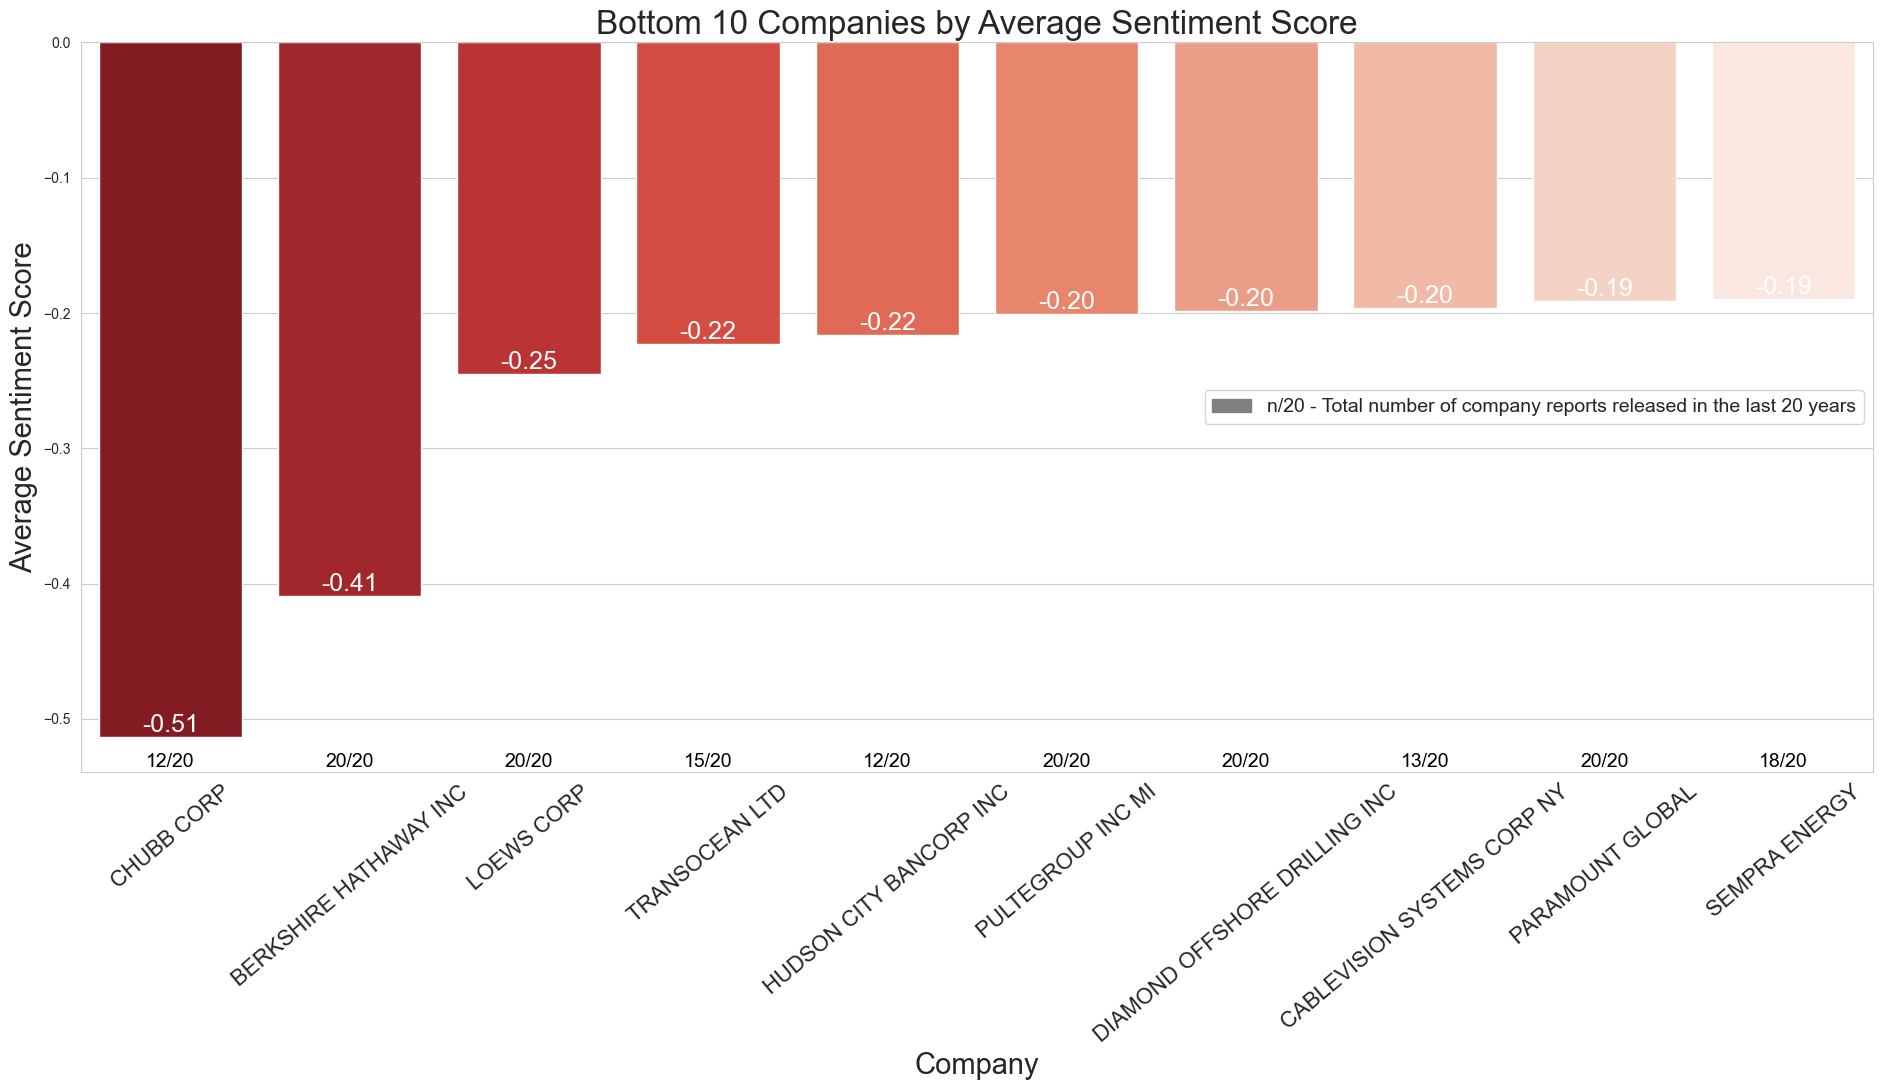

In [10]:
# Grouping data by Company Name and calculating the average sentiment score for each company
company_grouped = df.groupby('Company').agg({ 'Sentiment Score': 'mean', 'Total Reports by Company': 'first'}).reset_index()

# Sorting to find the top 10 and bottom 10 by Average Sentiment Score
top10_sentiment_score = company_grouped.nlargest(10, 'Sentiment Score')
bottom10_sentiment_score = company_grouped.nsmallest(10, 'Sentiment Score')

# Plot - Top 10 Average Sentiment Score by Company
plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
top_bar = sns.barplot(x='Company', y='Sentiment Score', data=top10_sentiment_score, palette='Greens_r')
plt.title('Top 10 Companies by Average Sentiment Score', size=24)
plt.xlabel('Company', size=21)
plt.ylabel('Average Sentiment Score', size=21)
plt.xticks(rotation=40, fontsize=16, verticalalignment='top')

# 'Total Reports by Company' annotation
for p in top_bar.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha="center", va='bottom', fontsize=18, color='black')
    company_presence = top10_sentiment_score.loc[top10_sentiment_score['Company'] == top_bar.get_xticklabels()[top_bar.patches.index(p)].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., -0.006, f'{company_presence}', ha="center", va='top', fontsize=14, color='black')

plt.tight_layout()
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)
plt.show()

# Plot - Bottom 10 Average Sentiment Score by Company
plt.figure(figsize=(19, 11))
bottom_bar = sns.barplot(x='Company', y='Sentiment Score', data=bottom10_sentiment_score, palette='Reds_r')
plt.title('Bottom 10 Companies by Average Sentiment Score', size=24)
plt.xlabel('Company', size=21)
plt.ylabel('Average Sentiment Score', size=21)
plt.xticks(rotation=40, fontsize=16, verticalalignment='top')

# 'Total Reports by Company' annotation
for p in bottom_bar.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha="center", va='bottom', fontsize=18, color='white')
    company_presence = bottom10_sentiment_score.loc[bottom10_sentiment_score['Company'] == bottom_bar.get_xticklabels()[bottom_bar.patches.index(p)].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., -0.525, f'{company_presence}', ha="center", va='top', fontsize=14, color='black')

plt.tight_layout()
proportion_patch = mpatches.Patch(color='Grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='center right', fontsize=14)
plt.show()

#### Top 5 and Bottom 5 By Year

In [11]:
#display(HTML("<style>.container { width:100% !important; }</style>"))

# Plot - Top 5 and bottom 5 Companies per yaer
def plot_data(year):
    global fig, ax  
    # Filtering and plotting code
    filtered_df = df[df['Year'] == int(year)]
    top_companies = filtered_df.nlargest(5, 'Sentiment Score').sort_values('Sentiment Score', ascending=False)
    bottom_companies = filtered_df.nsmallest(5, 'Sentiment Score').sort_values('Sentiment Score', ascending=False)
    combined_df = pd.concat([top_companies, bottom_companies])
    colors = ['green' if x in top_companies['Sentiment Score'].values else 'red' for x in combined_df['Sentiment Score']]
    
    fig, ax = plt.subplots(figsize=(13, 7)) 
    bars = ax.barh(combined_df['Company'], combined_df['Sentiment Score'], color=colors)
    ax.set_xlabel('Sentiment Score')
    ax.set_xlim(-1, 1)
    ax.set_title(f'Top and Bottom 5 Companies by Sentiment Score in {year}')
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')
    
    top_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor='none')
    bottom_bar = plt.Rectangle((0,0),1,1,fc='red', edgecolor='none')
    ax.legend([top_bar, bottom_bar], ['Top 5 Companies', 'Bottom 5 Companies'], loc='upper right')
    plt.show()

# Function to save the plot as PNG
def save_plot(_):
    filename = f'top_bottom_companies_sentiment_score_{year_dropdown.value}.png'
    fig.savefig(filename, format='png')
    print(f'Plot saved as {filename}')

# Dropdown for selecting the year
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in sorted(df['Year'].unique())],
    value=str(sorted(df['Year'].unique())[0]),
    description='Year:',
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)
ui = VBox([year_dropdown, save_button])
interactive_plot = widgets.interactive(plot_data, year=year_dropdown)

display(ui)
display(interactive_plot)


interactive(children=(Dropdown(description='Year:', options=('2004', '2005', '2006', '2007', '2008', '2009', '…

#### Top Companies by Avg. Sentiment Score by Company (Interactive plot)

In [12]:
# Functions to initialize the plot
def plot_data_companies(selected_companies):
    global fig  
    fig = go.Figure()

    if not selected_companies:
        avg_data = df.groupby('Year')['Sentiment Score'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=avg_data['Year'],
            y=avg_data['Sentiment Score'],
            mode='lines+markers',
            name='Average Sentiment Score',
            hoverinfo='all'
        ))
        title_text = "Average Sentiment Score Across All Companies"
    else:
        max_sentiment_score = 0
        company_names = []

        for company in selected_companies:
            company_data = df[df['Company'] == company].sort_values('Year')
            current_max = company_data['Sentiment Score'].max()
            if current_max > max_sentiment_score:
                max_sentiment_score = current_max

            fig.add_trace(go.Scatter(
                x=company_data['Year'],
                y=company_data['Sentiment Score'],
                mode='lines+markers',
                name=company,
                hoverinfo='all'
            ))

            company_names.append(company)

        title_text = f"Sentiment Score Time Series for {' & '.join(company_names)}"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Sentiment Score',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )
    
    fig.show()

# Function to save the plot
def save_plot_companies(_):
    if not company_dropdown.value:
        filename = 'average_sentiment_score_across_all_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'sentiment_score_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown for selecting the company with multiple selections enabled
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    description='Company:',
    disabled=False
)

# Save button
save_button_companies = Button(description="Save Plot")
save_button_companies.on_click(save_plot_companies)

# Combine the dropdown and button in a layout
ui_companies = VBox([company_dropdown, save_button_companies])
interact(plot_data_companies, selected_companies=company_dropdown)
display(ui_companies)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######


interactive(children=(SelectMultiple(description='Company:', options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE IN…

#### Variability in Sentiment Score by Year (NOT USEFUL)

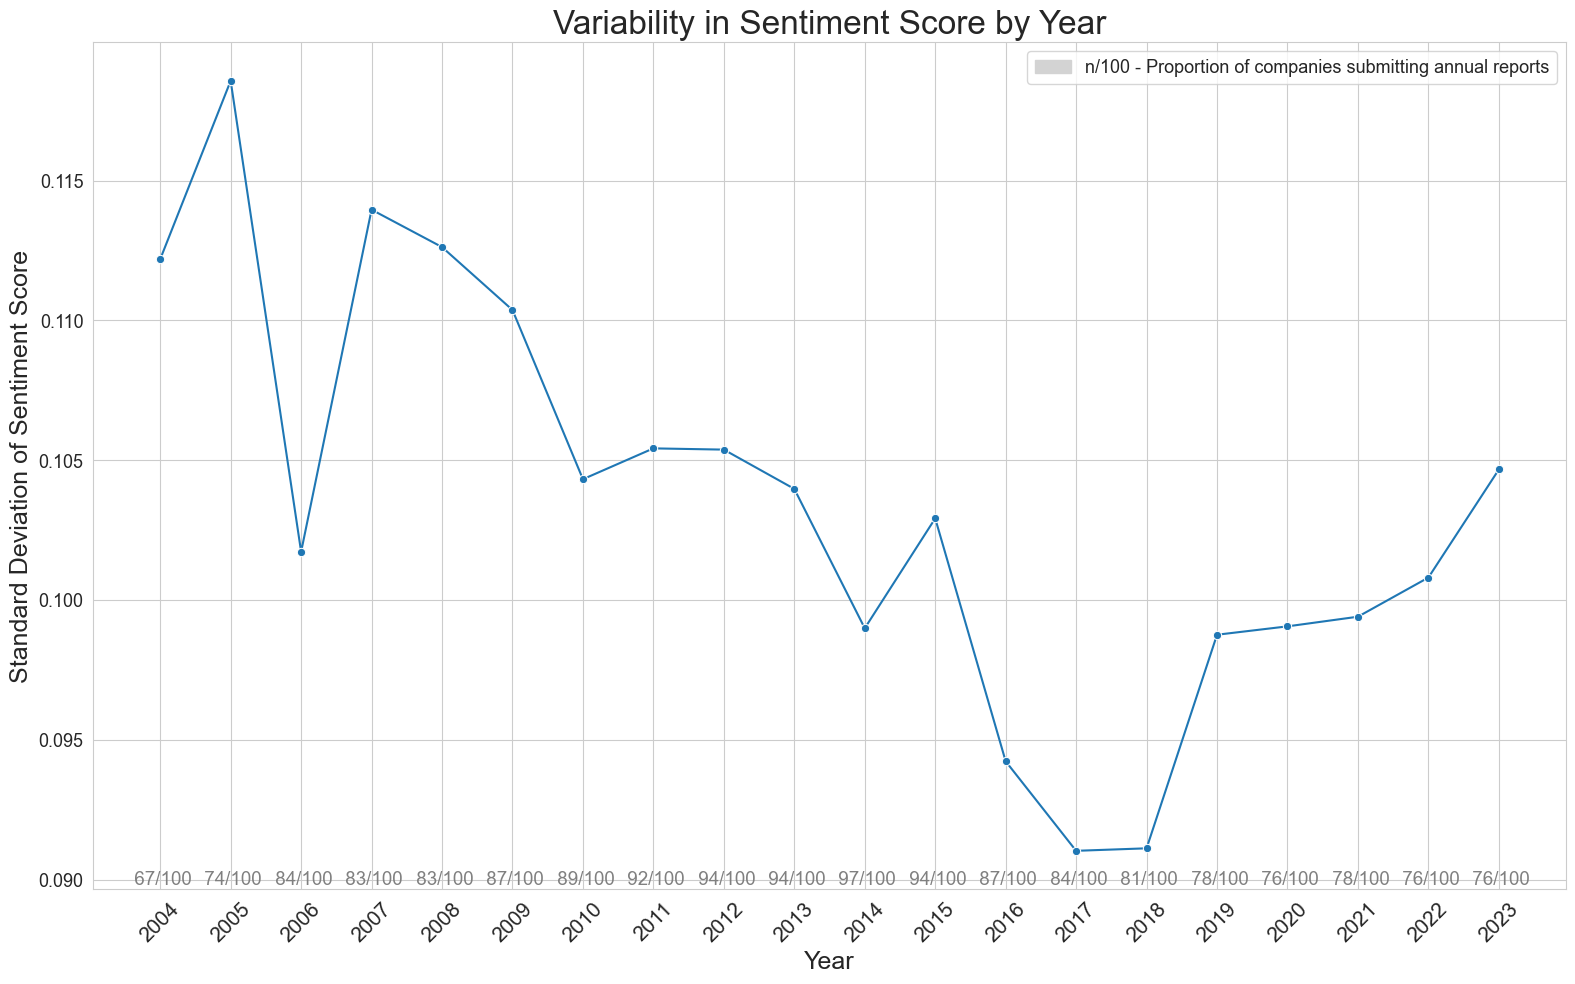

In [13]:
# ------- Calculating the variability of sentiment scores **within each year** -------
yearly_variability = df.groupby('Year')['Sentiment Score'].std().reset_index()
yearly_variability['Year'] = yearly_variability['Year'].astype(int)

# Add 'Company Presence by Year' annotations
yearly_variability = yearly_variability.merge(df[['Year', 'Company Presence by Year']].drop_duplicates(), on='Year', how='left')

# Plotting the variability of sentiment scores over years
plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
line_plot = sns.lineplot(x='Year', y='Sentiment Score', data=yearly_variability, marker='o')
plt.title('Variability in Sentiment Score by Year', size=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Standard Deviation of Sentiment Score', fontsize=18)
plt.xticks(yearly_variability['Year'], rotation=45, fontsize=15)
plt.yticks(fontsize=13)
plt.grid(True)

# 'Company Presence' annotations
for i, row in average_sentiment_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

proportion_patch = mpatches.Patch(color='lightgrey', label='n/100 - Proportion of companies submitting annual reports')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)

plt.show()

### Boilerplate Text analysis

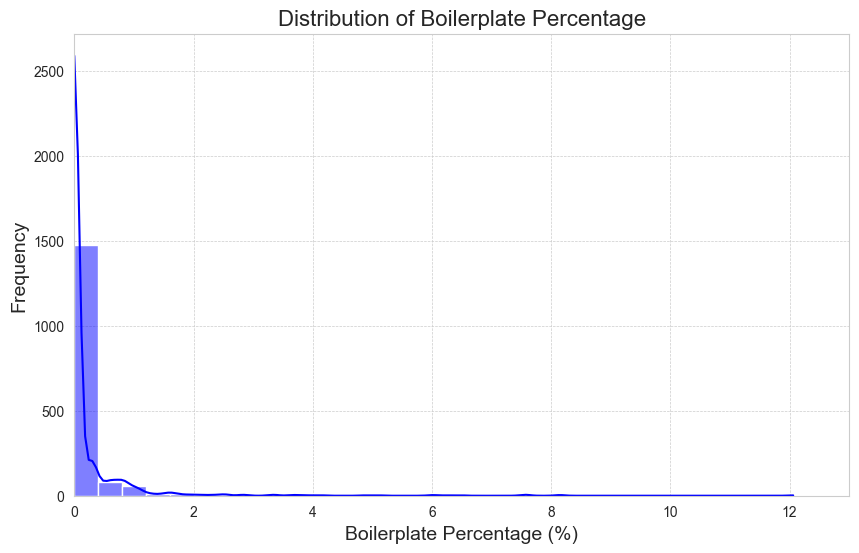

In [14]:
# Distribution plot (NOT USEFUL)
plt.figure(figsize=(10, 6))
sns.histplot(df['Boilerplate Percentage'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Boilerplate Percentage', fontsize=16)
plt.xlabel('Boilerplate Percentage (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 13)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

#### Average Boilerplate Language Over the Years

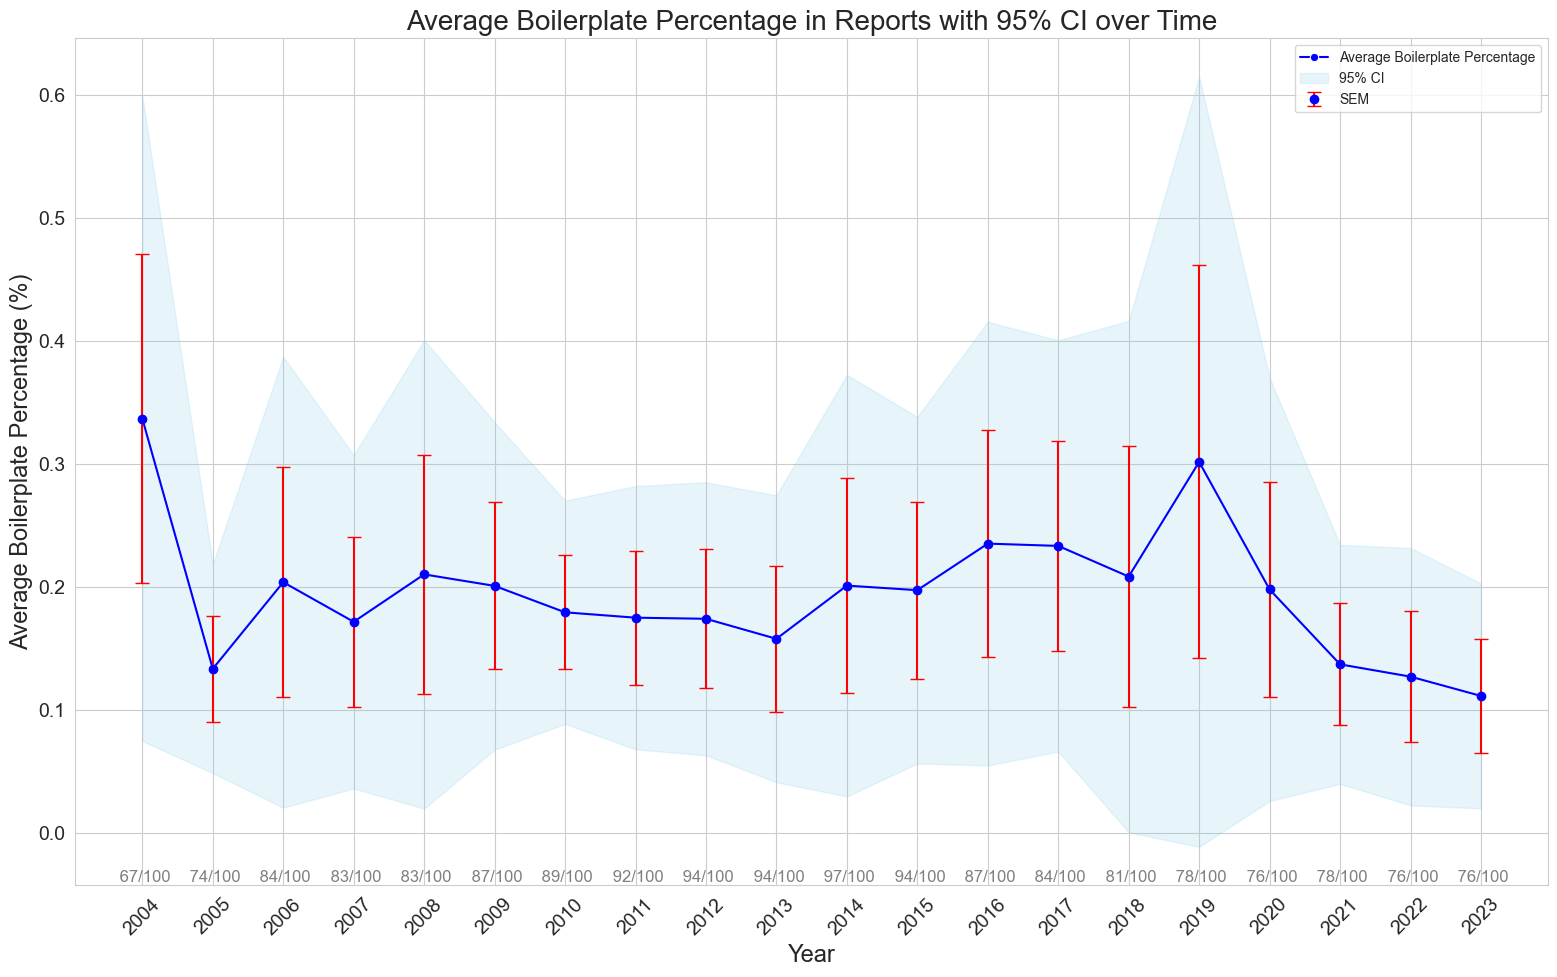

R² value: 0.0670
MSE: 0.0027
MAE: 0.0393


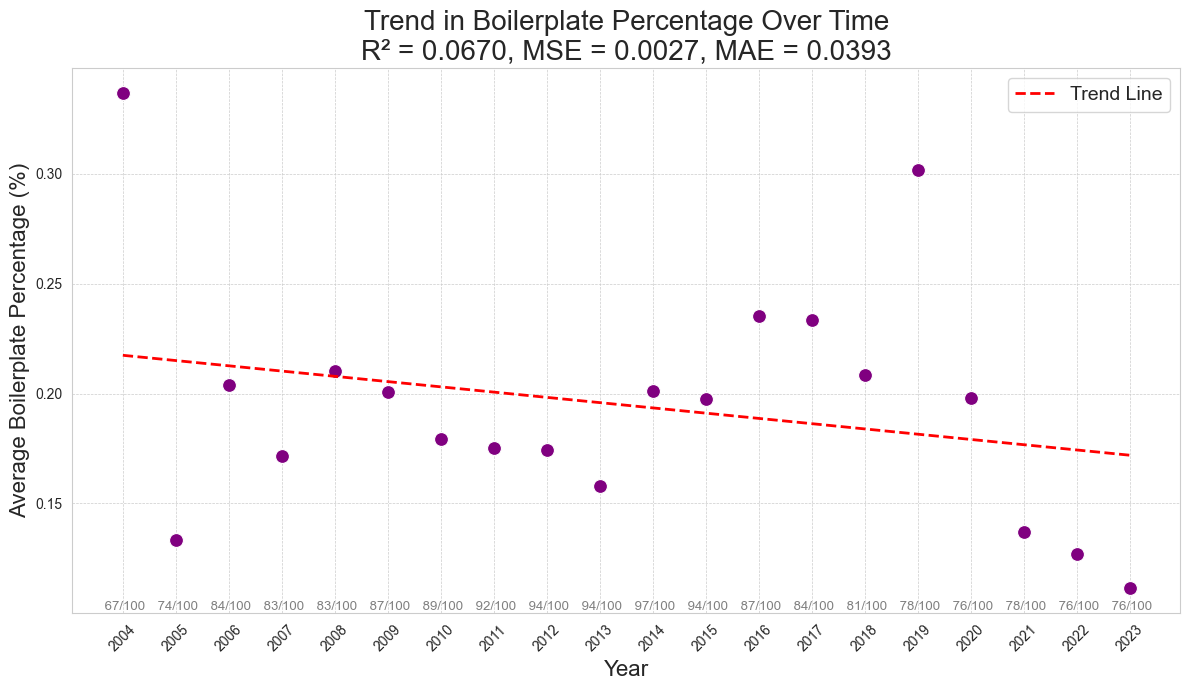

In [15]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean and SEM per year for Boilerplate Percentage
average_boilerplate_by_year = df.groupby('Year')['Boilerplate Percentage'].mean().reset_index()
average_boilerplate_by_year['SEM'] = df.groupby('Year')['Boilerplate Percentage'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))
ci_half_width = z_score * average_boilerplate_by_year['SEM']

average_boilerplate_by_year = average_boilerplate_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot - Avg Boilerplate language over time
plt.figure(figsize=(19, 11))

# Mean line and confidence interval
sns.lineplot(
    data=average_boilerplate_by_year,
    x='Year',
    y='Boilerplate Percentage',
    marker='o',
    color='blue',
    label='Average Boilerplate Percentage'
)
plt.fill_between(
    average_boilerplate_by_year['Year'],
    (average_boilerplate_by_year['Boilerplate Percentage'] - ci_half_width),
    (average_boilerplate_by_year['Boilerplate Percentage'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_boilerplate_by_year['Year'],
    average_boilerplate_by_year['Boilerplate Percentage'],
    yerr=average_boilerplate_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations
for i, row in average_boilerplate_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=12
    )

plt.title('Average Boilerplate Percentage in Reports with 95% CI over Time', fontsize=20)
plt.xlabel('Year', fontsize=17)
plt.ylabel('Average Boilerplate Percentage (%)', fontsize=17)
plt.xticks(average_boilerplate_by_year['Year'], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


# Plot - Linear regression to see the trend ( !! NOT USEFUL !! )
# Aggregate data by Year 
average_boilerplate_by_year = df.groupby('Year')['Boilerplate Percentage'].mean().reset_index()
average_boilerplate_by_year['SEM'] = df.groupby('Year')['Boilerplate Percentage'].sem().reset_index(drop=True)

# Linear Regression to identify trends
X_boilerplate = average_boilerplate_by_year[['Year']]
y_boilerplate = average_boilerplate_by_year['Boilerplate Percentage']
linear_regressor_boilerplate = LinearRegression()
linear_regressor_boilerplate.fit(X_boilerplate, y_boilerplate)
trend_line_boilerplate = linear_regressor_boilerplate.predict(X_boilerplate)

# Calculate R², MSE, and MAE values
r2_score_boilerplate = linear_regressor_boilerplate.score(X_boilerplate, y_boilerplate)
mse_boilerplate = mean_squared_error(y_boilerplate, trend_line_boilerplate)
mae_boilerplate = mean_absolute_error(y_boilerplate, trend_line_boilerplate)

print(f'R² value: {r2_score_boilerplate:.4f}')
print(f'MSE: {mse_boilerplate:.4f}')
print(f'MAE: {mae_boilerplate:.4f}')

# Merge 'Company Presence' data
average_boilerplate_by_year = average_boilerplate_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot the trend
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Year', y='Boilerplate Percentage', data=average_boilerplate_by_year, s=100, color='purple')
plt.plot(average_boilerplate_by_year['Year'], trend_line_boilerplate, color='red', linewidth=2, linestyle='--', label='Trend Line')
plt.title(f'Trend in Boilerplate Percentage Over Time\nR² = {r2_score_boilerplate:.4f}, MSE = {mse_boilerplate:.4f}, MAE = {mae_boilerplate:.4f}', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Average Boilerplate Percentage (%)', fontsize=16)
plt.xticks(np.arange(min(average_boilerplate_by_year['Year']), max(average_boilerplate_by_year['Year']) + 1, 1), rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 'Company Presence' annotations
for i, row in average_boilerplate_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=9.5
    )

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


#### Annual distribution of Boilerplate Percentage by Company

In [16]:
# Boxplot
fig = px.box(df, x='Year', y='Boilerplate Percentage', 
             labels={'Boilerplate Percentage': 'Boilerplate Percentage (%)'},
             hover_data=['Company'],
             title='Annual Distribution of Boilerplate Percentage by Company')

fig.update_traces(marker=dict(color='blue'))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Boilerplate Percentage (%)',
    plot_bgcolor='white',
    showlegend=False
)
# Details
fig.update_xaxes(showline=True, linewidth=2, linecolor='gray', gridcolor='lightgray', tickmode='linear', dtick=1)
fig.update_yaxes(showline=True, linewidth=2, linecolor='gray', gridcolor='lightgray', dtick=1)

fig.write_html("boilerplate_percentage_plot.html")
fig.show()


# PLot - Boilerplate over time for selected companies

# Calculate the mean boilerplate percentage for each company
avg_boilerplate = df.groupby('Company')['Boilerplate Percentage'].mean().sort_values(ascending=False)

# Identify the top 5 companies to plot the default graph
top_5_companies = avg_boilerplate.head(5).index.tolist()

# Plotting for the selected company
def plot_data(selected_companies):
    global fig  
    fig = go.Figure()

    if not selected_companies:
        selected_companies = top_5_companies
    
    max_boilerplate_percentage = 0
    company_names = []

    for company in selected_companies:
        company_data = df[df['Company'] == company].sort_values('Year')
        current_max = company_data['Boilerplate Percentage'].max()
        if current_max > max_boilerplate_percentage:
            max_boilerplate_percentage = current_max

        fig.add_trace(go.Scatter(
            x=company_data['Year'],
            y=company_data['Boilerplate Percentage'],
            mode='lines+markers',
            name=company,
            hoverinfo='all'
        ))

        company_names.append(company)

    title_text = f"Boilerplate Percentage Time Series for {' & '.join(company_names)}" if company_names else "Select a Company"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Boilerplate Percentage (%)',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

# Function to save the plot
def save_plot(_):
    if not company_dropdown.value:
        filename = 'boilerplate_percentage_top_5_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'boilerplate_percentage_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown menu
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    value=top_5_companies,
    description='Company:',
    disabled=False
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)
ui = VBox([company_dropdown, save_button])

interact(plot_data, selected_companies=company_dropdown)

# Displaying
display(ui)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######



interactive(children=(SelectMultiple(description='Company:', index=(52, 19, 25, 82, 54), options=('ABBVIE INC'…

### Most Frequent Words

#### Word Cloud for selected companies

Dropdown(description='Company:', index=9, options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE INC', 'ADT CORP', 'AF…

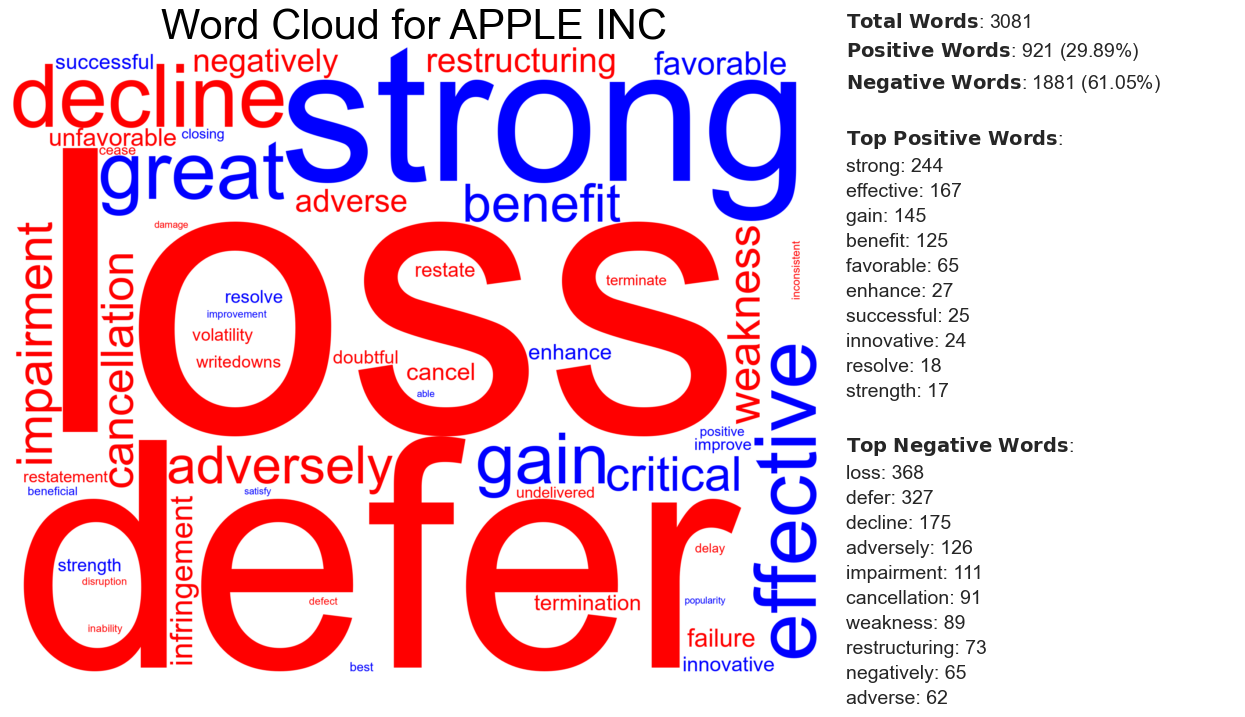

In [17]:
# Load the Loughran-McDonald dictionary again and, in this case, converting it into a pandas df
lm_dictionary_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/Loughran-McDonald_MasterDictionary_1993-2023.csv'
lm_dict = pd.read_csv(lm_dictionary_path)
positive_words = set(lm_dict[lm_dict['Positive'] > 0]['Word'].str.lower())
negative_words = set(lm_dict[lm_dict['Negative'] > 0]['Word'].str.lower())

# Manually adding 'benefit' and 'effective' to the list of positive words
positive_words.add('benefit')
positive_words.add('effective')

# Function to avoid parsing errors
def parse_key_words(row):
    if isinstance(row, str):
        try:
            return ast.literal_eval(row)
        except:
            return []
    return row
df['Key Sentiment Words'] = df['Key Sentiment Words'].apply(parse_key_words)

# Function to aggregate sentiment words for each company
def aggregate_sentiment_words(df):
    aggregated_words = {}
    for _, row in df.iterrows():
        company = row['Company']
        key_words = row['Key Sentiment Words']
        if company not in aggregated_words:
            aggregated_words[company] = Counter()
        for word, count in key_words:
            aggregated_words[company][word] += count
    return aggregated_words

aggregated_words = aggregate_sentiment_words(df)

# Function to generate and display a word cloud with more details
def generate_word_cloud(words, company, min_word_count=25):
    if len(words) >= min_word_count:
        wordcloud = WordCloud(
            width=2200, 
            height=1700,
            background_color='white',
            colormap='cool',
            min_font_size=15,
            max_words=50,
            collocations=False,
            color_func=lambda *args, **kwargs: 'red' if args[0] in negative_words else 'blue',
            font_path='arial.ttf'
        ).generate_from_frequencies(words)

        plt.figure(figsize=(13, 8))
        
        # Subplot with adjustable width ratio
        ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
        ax2 = plt.subplot2grid((1, 3), (0, 2))
        
        # Plot the wc
        ax1.imshow(wordcloud, interpolation="bilinear")
        ax1.set_title(f"Word Cloud for {company}", fontsize=30, color='black')
        ax1.axis("off")
        ax2.axis("off")
        
        # Adding additional details
        positive_word_count = sum(words[word] for word in words if word in positive_words)
        negative_word_count = sum(words[word] for word in words if word in negative_words)
        total_words = sum(words.values())

        top_positive_words = {word: count for word, count in words.items() if word in positive_words}
        top_negative_words = {word: count for word, count in words.items() if word in negative_words}

        top_positive_words_sorted = sorted(top_positive_words.items(), key=lambda item: item[1], reverse=True)[:10]
        top_negative_words_sorted = sorted(top_negative_words.items(), key=lambda item: item[1], reverse=True)[:10]

        legend_text = (
            f"$\\bf{{Total\\ Words}}$: {total_words}\n"
            f"$\\bf{{Positive\\ Words}}$: {positive_word_count} ({positive_word_count/total_words*100:.2f}%)\n"
            f"$\\bf{{Negative\\ Words}}$: {negative_word_count} ({negative_word_count/total_words*100:.2f}%)\n\n"
            f"$\\bf{{Top\\ Positive\\ Words}}$:\n" + "\n".join([f"{word}: {count}" for word, count in top_positive_words_sorted]) + "\n\n"
            f"$\\bf{{Top\\ Negative\\ Words}}$:\n" + "\n".join([f"{word}: {count}" for word, count in top_negative_words_sorted])
        )

        ax2.text(
            0, 0.5, legend_text, ha="left", va="center", fontsize=14, bbox=dict(facecolor='white', alpha=0.5), wrap=True, linespacing=1.5
        )

        plt.tight_layout(pad=2)
        plt.show()
    else:
        print(f"Not enough words to generate word cloud for {company}")

# Function to generate the word cloud depending on the company selected
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        company = change['new']
        if company in aggregated_words:
            generate_word_cloud(aggregated_words[company], company)
        else:
            print(f"No words found for company {company}")

# Dropdown to select a company, with "Apple Inc" as default comp.
dropdown = widgets.Dropdown(
    options=sorted(aggregated_words.keys()),
    description='Company:',
    value='APPLE INC', 
    disabled=False
)
dropdown.observe(on_change)

display(dropdown)

# Word cloud for Apple, the default company
generate_word_cloud(aggregated_words['APPLE INC'], 'APPLE INC')


### Readability Analysis

#### Sentence Analysis

##### Top Companies by Max Sentence Lenght 

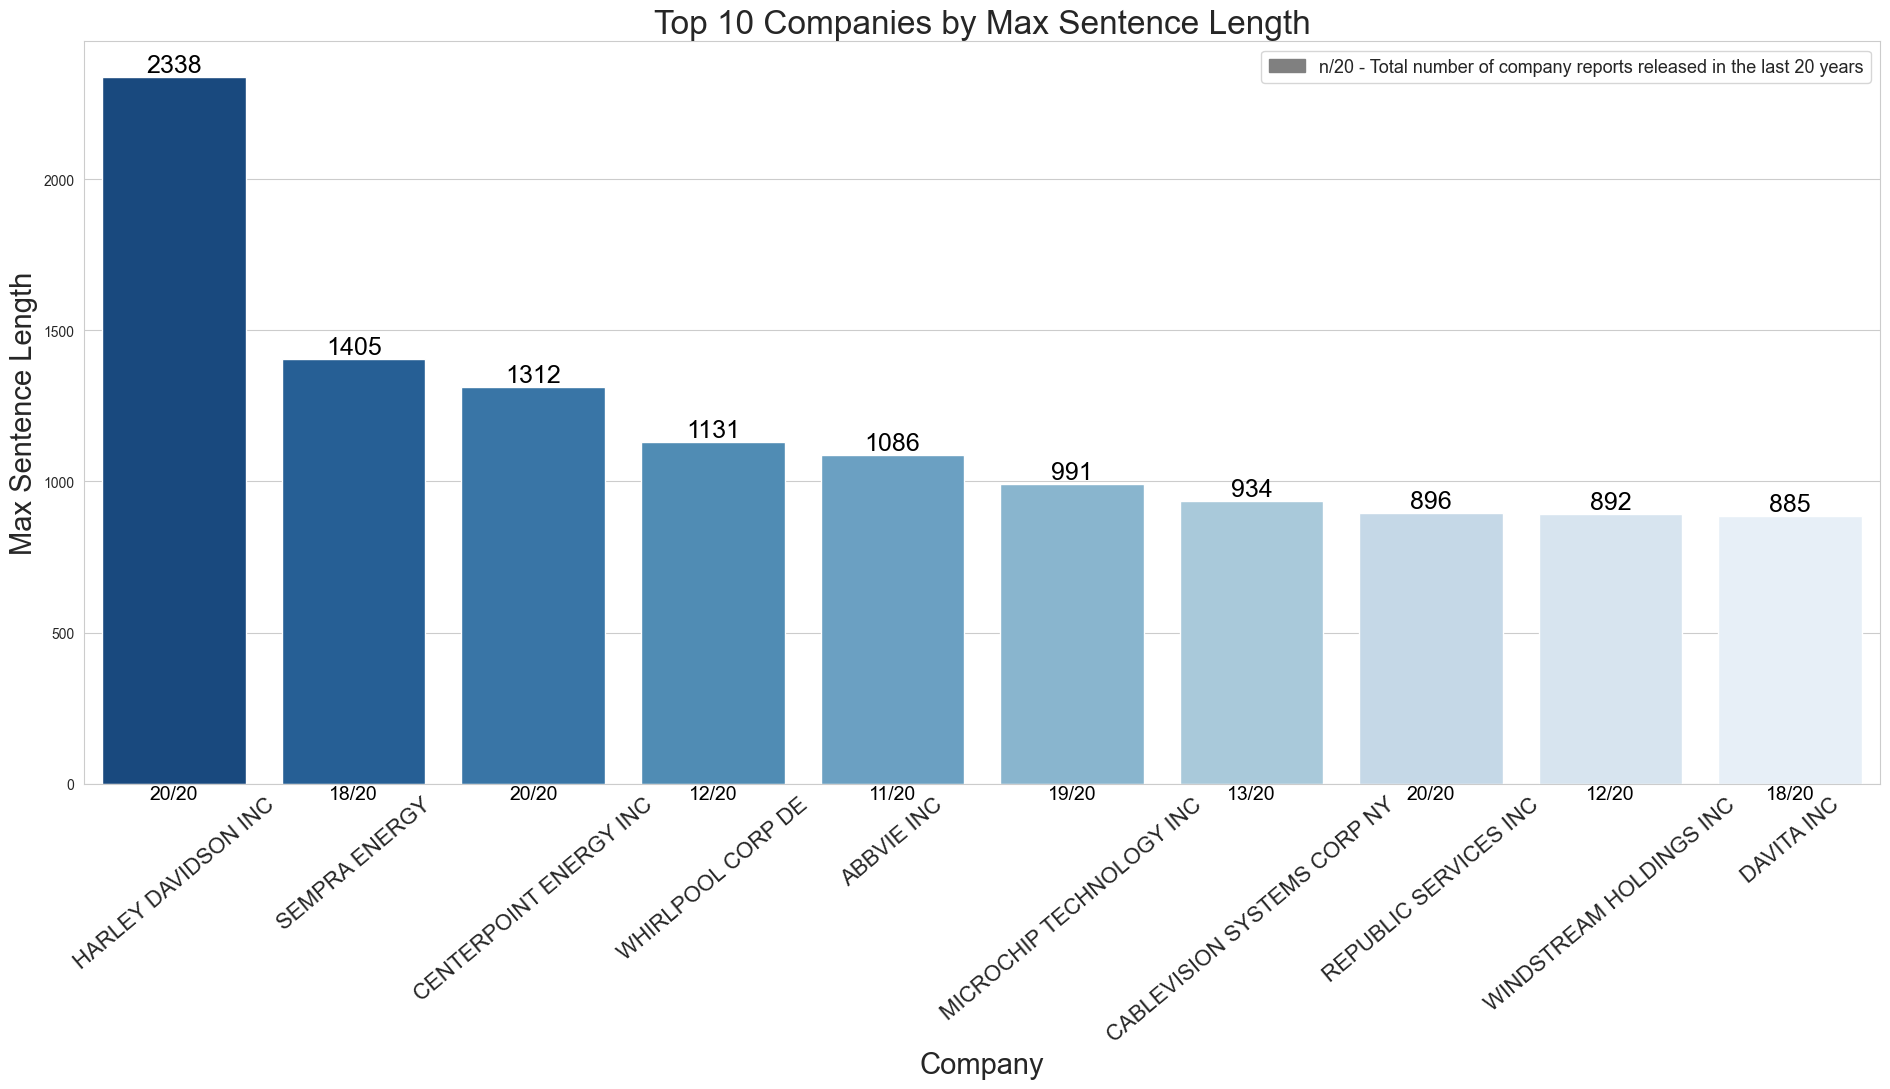

In [18]:
# Grouping companies and max sentence length for each company
company_grouped = df.groupby('Company').agg({'Max Sentence Length': 'max', 'Total Reports by Company': 'first'}).reset_index()

# Top 10 companies by Max Sentence Length
top10_max_sentence_length = company_grouped.nlargest(10, 'Max Sentence Length')

# PLot - Top 10 Companies by Max Sentence Length
plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
top_bar = sns.barplot(x='Company', y='Max Sentence Length', data=top10_max_sentence_length, palette='Blues_r')
plt.title('Top 10 Companies by Max Sentence Length', size=24)
plt.xlabel('Company', size=21)
plt.ylabel('Max Sentence Length', size=21)
plt.xticks(rotation=40, fontsize=16, verticalalignment='top')

# Annotating 'Total Reports by Company' 
for p in top_bar.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{int(height)}', ha="center", va='bottom', fontsize=18, color='black')
    company_presence = top10_max_sentence_length.loc[top10_max_sentence_length['Company'] == top_bar.get_xticklabels()[top_bar.patches.index(p)].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., -5, f'{company_presence}', ha="center", va='top', fontsize=14, color='black')

plt.tight_layout()
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)
plt.show()


#### Readability Indexes - All Companies

In [19]:
# Plots - Readability indices
# Calculate average values per year
avg_flesch_kincaid_by_year = df.groupby('Year')['Flesch-Kincaid Grade Level'].mean().reset_index()
avg_flesch_reading_ease_by_year = df.groupby('Year')['Flesch Reading Ease'].mean().reset_index()
avg_gunning_fog_by_year = df.groupby('Year')['Gunning-Fog Index'].mean().reset_index()

# Flesch-Kincaid Grade Level plot by year
fig1 = px.line(avg_flesch_kincaid_by_year, x='Year', y='Flesch-Kincaid Grade Level', title='Average Flesch-Kincaid Grade Level by Year', markers=True)
fig1.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Flesch-Kincaid Grade Level',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)
fig1.add_hrect(y0=0, y1=5, fillcolor="green", opacity=0.1, line_width=0, annotation_text="0-5: Very easy", annotation_position="inside top left")
fig1.add_hrect(y0=5, y1=8, fillcolor="yellow", opacity=0.1, line_width=0, annotation_text="6-8: Easy", annotation_position="inside top left")
fig1.add_hrect(y0=8, y1=12, fillcolor="orange", opacity=0.1, line_width=0, annotation_text="9-12: Fairly difficult", annotation_position="inside top left")
fig1.add_hrect(y0=12, y1=20, fillcolor="red", opacity=0.1, line_width=0, annotation_text="Above 12: Difficult", annotation_position="inside top left")

# Flesch Reading Ease plot by year
fig2 = px.line(avg_flesch_reading_ease_by_year, x='Year', y='Flesch Reading Ease', title='Average Flesch Reading Ease by Year', markers=True)
fig2.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Flesch Reading Ease',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)
fig2.add_hrect(y0=90, y1=100, fillcolor="green", opacity=0.1, line_width=0, annotation_text="90-100: Very easy", annotation_position="inside top left")
fig2.add_hrect(y0=80, y1=90, fillcolor="lightgreen", opacity=0.1, line_width=0, annotation_text="80-89: Easy", annotation_position="inside top left")
fig2.add_hrect(y0=70, y1=80, fillcolor="yellow", opacity=0.1, line_width=0, annotation_text="70-79: Fairly easy", annotation_position="inside top left")
fig2.add_hrect(y0=60, y1=70, fillcolor="orange", opacity=0.1, line_width=0, annotation_text="60-69: Standard", annotation_position="inside top left")
fig2.add_hrect(y0=50, y1=60, fillcolor="orangered", opacity=0.1, line_width=0, annotation_text="50-59: Fairly difficult", annotation_position="inside top left")
fig2.add_hrect(y0=30, y1=50, fillcolor="red", opacity=0.1, line_width=0, annotation_text="30-49: Difficult", annotation_position="inside top left")
fig2.add_hrect(y0=0, y1=30, fillcolor="darkred", opacity=0.1, line_width=0, annotation_text="0-29: Very confusing", annotation_position="inside top left")

# Gunning Fog Index plot by year
fig3 = px.line(avg_gunning_fog_by_year, x='Year', y='Gunning-Fog Index', title='Average Gunning-Fog Index by Year', markers=True)
fig3.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Gunning-Fog Index',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)
fig3.add_hrect(y0=0, y1=6, fillcolor="green", opacity=0.1, line_width=0, annotation_text="6: Readable for 6th grade", annotation_position="inside top left")
fig3.add_hrect(y0=6, y1=8, fillcolor="lightgreen", opacity=0.1, line_width=0, annotation_text="7-8: 7th to 8th grade", annotation_position="inside top left")
fig3.add_hrect(y0=8, y1=10, fillcolor="yellow", opacity=0.1, line_width=0, annotation_text="9-10: High school level", annotation_position="inside top left")
fig3.add_hrect(y0=10, y1=12, fillcolor="orange", opacity=0.1, line_width=0, annotation_text="11-12: College level", annotation_position="inside top left")
fig3.add_hrect(y0=12, y1=16, fillcolor="red", opacity=0.1, line_width=0, annotation_text="13-16: College graduate level", annotation_position="inside top left")
fig3.add_hrect(y0=16, y1=30, fillcolor="darkred", opacity=0.1, line_width=0, annotation_text="17+: Postgraduate level", annotation_position="inside top left")

# Save the plots as HTML
fig1.write_html('avg_flesch_kincaid_by_year.html')
fig2.write_html('avg_flesch_reading_ease_by_year.html')
fig3.write_html('avg_gunning_fog_by_year.html')

fig1.show()
fig2.show()
fig3.show()


#### Readability Index - Selected Hi-Tech Companies

In [20]:
# List of our specific companies to plot
companies = ['APPLE INC', 'AMAZON COM INC', 'NETFLIX INC', 'PARAMOUNT GLOBAL', 'INTEL CORP', 'NVIDIA CORP', 'EBAY INC', 'META PLATFORMS INC', 'ORACLE CORP', 'ELECTRONIC ARTS INC', 'ADOBE INC']

filtered_df = df[df['Company'].isin(companies)]

# Flesch-Kincaid Grade Level plot by year for our specific companies
fig1 = px.line(filtered_df, x='Year', y='Flesch-Kincaid Grade Level', color='Company', title='Flesch-Kincaid Grade Level by Year for Specific Companies', markers=True)
fig1.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Flesch-Kincaid Grade Level',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=filtered_df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)

fig1.add_hrect(y0=9, y1=12, fillcolor="orange", opacity=0.1, line_width=0, annotation_text="9-12: Fairly difficult", annotation_position="inside top left")
fig1.add_hrect(y0=12, y1=20, fillcolor="red", opacity=0.1, line_width=0, annotation_text="Above 12: Difficult", annotation_position="inside top left")

# Flesch Reading Ease plot by year for our specific companies
fig2 = px.line(filtered_df, x='Year', y='Flesch Reading Ease', color='Company', title='Flesch Reading Ease by Year for Specific Companies', markers=True)
fig2.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Flesch Reading Ease',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=filtered_df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)
fig2.add_hrect(y0=50, y1=59, fillcolor="orangered", opacity=0.1, line_width=0, annotation_text="50-59: Fairly difficult", annotation_position="inside top left")
fig2.add_hrect(y0=30, y1=50, fillcolor="red", opacity=0.1, line_width=0, annotation_text="30-49: Difficult", annotation_position="inside top left")
fig2.add_hrect(y0=0, y1=30, fillcolor="darkred", opacity=0.1, line_width=0, annotation_text="0-29: Very confusing", annotation_position="inside top left")

# Gunning Fog Index plot by year for our specific companies
fig3 = px.line(filtered_df, x='Year', y='Gunning-Fog Index', color='Company', title='Gunning-Fog Index by Year for Specific Companies', markers=True)
fig3.update_layout(
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis_title='Year',
    yaxis_title='Gunning-Fog Index',
    xaxis=dict(showline=True, showgrid=True, tickmode='linear', tick0=filtered_df['Year'].min(), dtick=1, linecolor='gray', gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, linecolor='gray', gridcolor='lightgray'),
    font=dict(family="Arial, sans-serif", size=12, color="black")
)
fig3.add_hrect(y0=7, y1=8, fillcolor="lightgreen", opacity=0.1, line_width=0, annotation_text="7-8: 7th to 8th grade", annotation_position="inside top left")
fig3.add_hrect(y0=8, y1=10, fillcolor="yellow", opacity=0.1, line_width=0, annotation_text="9-10: High school level", annotation_position="inside top left")
fig3.add_hrect(y0=10, y1=12, fillcolor="orange", opacity=0.1, line_width=0, annotation_text="11-12: College level", annotation_position="inside top left")
fig3.add_hrect(y0=12, y1=16, fillcolor="red", opacity=0.1, line_width=0, annotation_text="13-16: College graduate level", annotation_position="inside top left")

fig1.write_html('flesch_kincaid_by_company.html')
fig2.write_html('flesch_reading_ease_by_company.html')
fig3.write_html('gunning_fog_by_company.html')

fig1.show()
fig2.show()
fig3.show()


## Predictive Models

### Boilerplate Percentage Prediction

##### Prophet model

03:47:19 - cmdstanpy - INFO - Chain [1] start processing
03:47:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model - MSE: 0.0023, MAE: 0.0370, R²: 0.2070


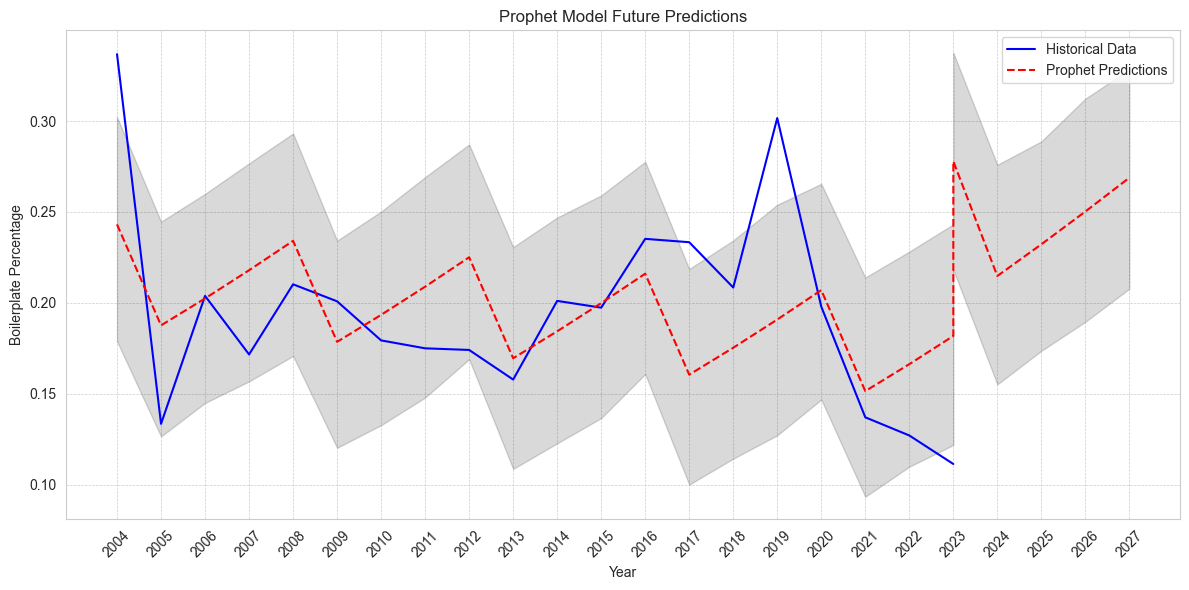


Prophet Model Future Predictions:
Year: 2024, Predicted Boilerplate Percentage: 0.21476386765001163
Year: 2025, Predicted Boilerplate Percentage: 0.23220298633232306
Year: 2026, Predicted Boilerplate Percentage: 0.2502363007383157
Year: 2027, Predicted Boilerplate Percentage: 0.26883748365896687


In [21]:
# New DataFrame for modifications
df1 = df.copy()

# Aggr data by Year
df1_agg = df1.groupby('Year').agg({
    'Boilerplate Percentage': 'mean'
}).reset_index()

# Rename columns for Prophet
df1_agg.rename(columns={'Year': 'ds', 'Boilerplate Percentage': 'y'}, inplace=True)

# Convert 'ds' to datetime format for compatibility with Prophet
df1_agg['ds'] = pd.to_datetime(df1_agg['ds'], format='%Y')

# Initialize the Prophet model
model_prophet = Prophet()
model_prophet.fit(df1_agg)

# Make future predictions for the next 5 years 
future = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast_prophet = model_prophet.predict(future)
historical_prophet = forecast_prophet[forecast_prophet['ds'] <= '2023-12-31']

# Merge the historical predictions back with the actual data
merged_prophet = pd.merge(df1_agg, historical_prophet[['ds', 'yhat']], on='ds', how='left')

# Evaluate the Prophet model on historical data
mse_prophet = mean_squared_error(merged_prophet['y'], merged_prophet['yhat'])
mae_prophet = mean_absolute_error(merged_prophet['y'], merged_prophet['yhat'])
r2_prophet = r2_score(merged_prophet['y'], merged_prophet['yhat'])

# Prophet performance metrics
print(f'Prophet Model - MSE: {mse_prophet:.4f}, MAE: {mae_prophet:.4f}, R²: {r2_prophet:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(df1_agg['ds'].dt.year, df1_agg['y'], label='Historical Data', color='blue')
plt.plot(forecast_prophet['ds'].dt.year, forecast_prophet['yhat'], label='Prophet Predictions', color='red', linestyle='--')
plt.fill_between(forecast_prophet['ds'].dt.year, forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color='k', alpha=.15)
plt.xlabel('Year')
plt.ylabel('Boilerplate Percentage')
plt.title('Prophet Model Future Predictions')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(min(df1_agg['ds'].dt.year), max(forecast_prophet['ds'].dt.year) + 1), rotation=45)
plt.tight_layout()
plt.show()


# Print the future predictions for the Prophet model
print("\nProphet Model Future Predictions:")
future_predictions_prophet = forecast_prophet[forecast_prophet['ds'] > '2023-12-31']
for _, row in future_predictions_prophet.iterrows():
    print(f"Year: {row['ds'].year}, Predicted Boilerplate Percentage: {row['yhat']}")

##### Prophet, LSTM (nn) and Random Forest models and their comparison.

03:47:20 - cmdstanpy - INFO - Chain [1] start processing
03:47:20 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 24ms/step
Fitting 3 folds for each of 100 candidates, totalling 300 fits


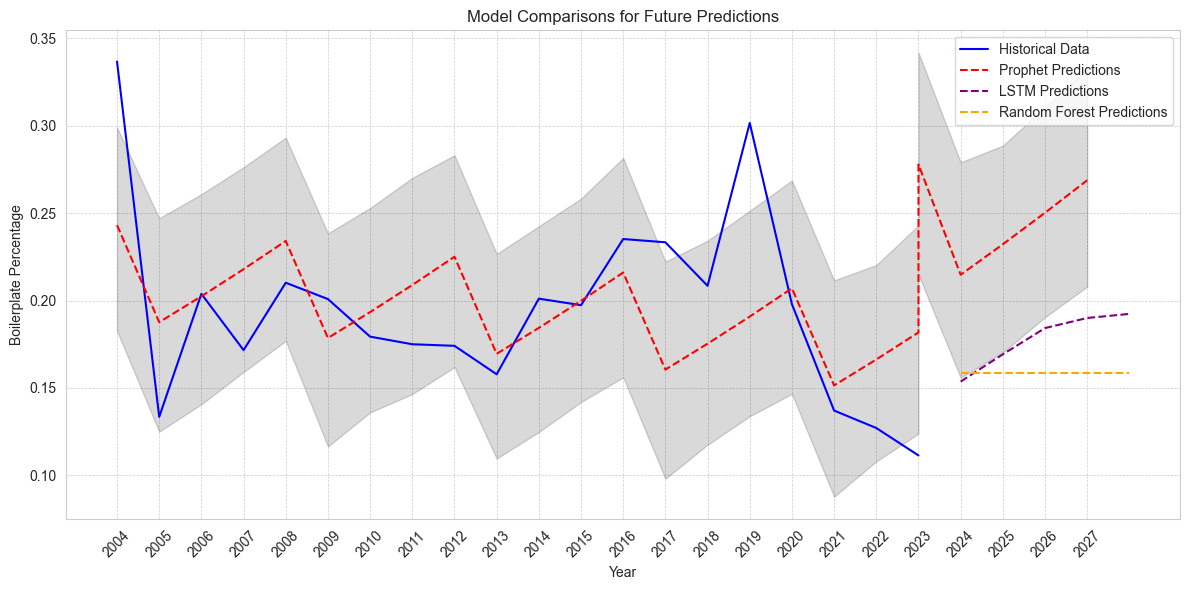


Prophet Model Future Predictions:
Year: 2024, Predicted Boilerplate Percentage: 0.21476386765001163
Year: 2025, Predicted Boilerplate Percentage: 0.23220298633232306
Year: 2026, Predicted Boilerplate Percentage: 0.2502363007383157
Year: 2027, Predicted Boilerplate Percentage: 0.26883748365896687

LSTM Model Future Predictions:
Year: 2024, Predicted Boilerplate Percentage: [0.15361728]
Year: 2025, Predicted Boilerplate Percentage: [0.1692173]
Year: 2026, Predicted Boilerplate Percentage: [0.184234]
Year: 2027, Predicted Boilerplate Percentage: [0.19001074]
Year: 2028, Predicted Boilerplate Percentage: [0.19234677]

Random Forest Model Future Predictions:
Year: 2024, Predicted Boilerplate Percentage: 0.1586455309641768
Year: 2025, Predicted Boilerplate Percentage: 0.1586455309641768
Year: 2026, Predicted Boilerplate Percentage: 0.1586455309641768
Year: 2027, Predicted Boilerplate Percentage: 0.1586455309641768
Year: 2028, Predicted Boilerplate Percentage: 0.1586455309641768

Prophet Mod

In [22]:
# Create a new DataFrame for modifications
df2 = df.copy()

# Aggr data by Year
df2_agg = df2.groupby('Year').agg({
    'Boilerplate Percentage': 'mean'
}).reset_index()

# Prophet Model again
df2_agg_prophet = df2_agg.rename(columns={'Year': 'ds', 'Boilerplate Percentage': 'y'})
df2_agg_prophet['ds'] = pd.to_datetime(df2_agg_prophet['ds'], format='%Y')

model_prophet = Prophet()
model_prophet.fit(df2_agg_prophet)
future_prophet = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast_prophet = model_prophet.predict(future_prophet)
historical_prophet = forecast_prophet[forecast_prophet['ds'] <= '2023-12-31']
merged_prophet = pd.merge(df2_agg_prophet, historical_prophet[['ds', 'yhat']], on='ds', how='left')
mse_prophet = mean_squared_error(merged_prophet['y'], merged_prophet['yhat'])
mae_prophet = mean_absolute_error(merged_prophet['y'], merged_prophet['yhat'])
r2_prophet = r2_score(merged_prophet['y'], merged_prophet['yhat'])

# LSTM Model
df2_lstm = df2_agg.set_index('Year')
scaler = MinMaxScaler()
df2_lstm['Boilerplate Percentage'] = scaler.fit_transform(df2_lstm[['Boilerplate Percentage']])

time_steps = 3
X_lstm = []
y_lstm = []
for i in range(time_steps, len(df2_lstm)):
    X_lstm.append(df2_lstm.iloc[i-time_steps:i, 0])
    y_lstm.append(df2_lstm.iloc[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_lstm, y_lstm, epochs=100, batch_size=1, verbose=0)

# Predict future values with LSTM
X_lstm_future = df2_lstm[-time_steps:].values.reshape(1, time_steps, 1)
future_lstm_predictions = []
for _ in range(5):
    y_future_pred = model_lstm.predict(X_lstm_future)
    future_lstm_predictions.append(y_future_pred[0, 0])
    X_lstm_future = np.roll(X_lstm_future, -1)
    X_lstm_future[0, -1, 0] = y_future_pred

future_lstm_predictions = scaler.inverse_transform(np.array(future_lstm_predictions).reshape(-1, 1))

y_pred_lstm = model_lstm.predict(X_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_lstm = scaler.inverse_transform(y_lstm.reshape(-1, 1))

mse_lstm = mean_squared_error(y_lstm, y_pred_lstm)
mae_lstm = mean_absolute_error(y_lstm, y_pred_lstm)
r2_lstm = r2_score(y_lstm, y_pred_lstm)

# Random Forest Model with Parameter Optimization
df2_agg_rf = df2_agg.copy()
for lag in range(1, 4):
    df2_agg_rf[f'lag_{lag}'] = df2_agg_rf['Boilerplate Percentage'].shift(lag)
df2_agg_rf.dropna(inplace=True)

X_rf = df2_agg_rf[['Year'] + [f'lag_{lag}' for lag in range(1, 4)]].copy()
y_rf = df2_agg_rf['Boilerplate Percentage'].values

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(np.arange(10, 40, 5)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                   param_distributions=param_distributions, 
                                   n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_rf, y_train_rf)
best_rf_model = random_search.best_estimator_

trend_line_rf = best_rf_model.predict(X_rf)

mse_rf = mean_squared_error(y_rf, trend_line_rf)
mae_rf = mean_absolute_error(y_rf, trend_line_rf)
r2_rf = r2_score(y_rf, trend_line_rf)

# Forecasting with Random Forest 
X_future_rf = pd.DataFrame({
    'Year': range(df2_agg_rf['Year'].max() + 1, df2_agg_rf['Year'].max() + 6),
    'lag_1': df2_agg_rf['Boilerplate Percentage'].iloc[-1],
    'lag_2': df2_agg_rf['Boilerplate Percentage'].iloc[-2],
    'lag_3': df2_agg_rf['Boilerplate Percentage'].iloc[-3]
})
forecast_rf = best_rf_model.predict(X_future_rf)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df2_agg['Year'], df2_agg['Boilerplate Percentage'], label='Historical Data', color='blue')
plt.plot(forecast_prophet['ds'].dt.year, forecast_prophet['yhat'], label='Prophet Predictions', color='red', linestyle='--')
plt.plot(range(2024, 2029), future_lstm_predictions, label='LSTM Predictions', color='purple', linestyle='--')
plt.plot(X_future_rf['Year'], forecast_rf, label='Random Forest Predictions', color='orange', linestyle='--')
plt.fill_between(forecast_prophet['ds'].dt.year, forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color='k', alpha=.15)
plt.xlabel('Year')
plt.ylabel('Boilerplate Percentage')
plt.title('Model Comparisons for Future Predictions')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(min(df2['Year']), max(forecast_prophet['ds'].dt.year) + 1), rotation=45)
plt.tight_layout()
plt.show()

# Predictions for each model
print("\nProphet Model Future Predictions:")
for _, row in forecast_prophet[forecast_prophet['ds'] > '2023-12-31'].iterrows():
    print(f"Year: {row['ds'].year}, Predicted Boilerplate Percentage: {row['yhat']}")

print("\nLSTM Model Future Predictions:")
for year, pred in zip(range(2024, 2029), future_lstm_predictions):
    print(f"Year: {year}, Predicted Boilerplate Percentage: {pred}")

print("\nRandom Forest Model Future Predictions:")
for ds, yhat in zip(X_future_rf['Year'], forecast_rf):
    print(f"Year: {ds}, Predicted Boilerplate Percentage: {yhat}")

# Performance metrics
print(f'\nProphet Model - MSE: {mse_prophet:.4f}, MAE: {mae_prophet:.4f}, R²: {r2_prophet:.4f}')
print(f'LSTM Model - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'Random Forest Model - MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}')
